<a href="https://colab.research.google.com/github/Selenaxuuuu/Stock-Forecast/blob/main/Stock_Selection_%26_Price%26_Risk_Complete_Edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("borismarjanovic/price-volume-data-for-all-us-stocks-etfs")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'price-volume-data-for-all-us-stocks-etfs' dataset.
Path to dataset files: /kaggle/input/price-volume-data-for-all-us-stocks-etfs


In [3]:
import os

# Print the download path to see what folders are inside
print(f"Data downloaded to: {path}")
print("Content of the folder:", os.listdir(path))

# Usually this dataset contains two subfolders: 'Stocks' and 'ETFs'
# We target the ETFs folder
stocks_path = os.path.join(path, 'Stocks')

if os.path.exists(stocks_path):
    print(f"Found Stocks folder: {stocks_path}")
    # Check the first 5 filenames to see if they are txt or csv
    print("First 5 files:", os.listdir(stocks_path)[:5])
else:
    print("Stocks folder not found, please check the print output above")

Data downloaded to: /kaggle/input/price-volume-data-for-all-us-stocks-etfs
Content of the folder: ['Stocks', 'ETFs', 'Data']
Found Stocks folder: /kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks
First 5 files: ['ufi.us.txt', 'vfl.us.txt', 'sohu.us.txt', 'rdcm.us.txt', 'virt.us.txt']


In [4]:
import pandas as pd
import glob
from tqdm import tqdm # Progress bar tool to let you know where processing is at

# Get paths of all txt files
# This dataset usually ends with .txt and is comma-separated
all_files = glob.glob(os.path.join(stocks_path, "*.txt"))

# Key step: To prevent memory overflow, we only take the first 1344 files
# (If you want to run all, you can remove [:1500], but Colab might crash)
target_files = all_files[:1344]

print(f"Total {len(all_files)} files, we will process the first {len(target_files)}...")

# Loop to read
df_list = []

# Use tqdm to display progress bar
for filename in tqdm(target_files):
    try:
        # Read file (this dataset usually has no header, or the header is Date,Open,High,Low,Close,Volume,OpenInt)
        # Add on_bad_lines='skip' to prevent errors caused by bad data in a row
        temp_df = pd.read_csv(filename, sep=',', on_bad_lines='skip')

        # Extract filename as Ticker (e.g., 'aapl.us.txt' -> 'aapl')
        ticker_name = os.path.basename(filename).split('.')[0].upper()
        temp_df['Ticker'] = ticker_name

        # Simple cleaning: unify column names to lowercase or capitalized
        temp_df.columns = [c.capitalize() for c in temp_df.columns]

        df_list.append(temp_df)
    except Exception as e:
        print(f"Failed to read {filename}: {e}")

# Merge
print("Merging large table...")
full_df = pd.concat(df_list, axis=0, ignore_index=True)

# Format standardization
# Ensure column names are what we need: Date, Open, High, Low, Close, Volume, OpenInt
# Make a renaming mapping here to prevent column name mismatch
full_df = full_df.rename(columns={'Date': 'Date', 'Open': 'Open', 'High': 'High',
                                  'Low': 'Low', 'Close': 'Close', 'Volume': 'Volume',
                                  'Openint': 'OpenInt'})

full_df['Date'] = pd.to_datetime(full_df['Date'])
full_df = full_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

print("Merge complete!")
print(full_df.info())
print(full_df.head())

Total 7195 files, we will process the first 1344...


  6%|▌         | 83/1344 [00:02<00:38, 32.82it/s]

Failed to read /kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/sbt.us.txt: No columns to parse from file


  8%|▊         | 107/1344 [00:03<00:42, 29.24it/s]

Failed to read /kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/srva.us.txt: No columns to parse from file


 40%|███▉      | 535/1344 [00:14<00:12, 66.76it/s]

Failed to read /kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/pxus.us.txt: No columns to parse from file


 98%|█████████▊| 1322/1344 [00:25<00:00, 83.05it/s]

Failed to read /kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/stnl.us.txt: No columns to parse from file


100%|██████████| 1344/1344 [00:25<00:00, 52.76it/s]


Merging large table...
Merge complete!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2778431 entries, 0 to 2778430
Data columns (total 8 columns):
 #   Column   Dtype         
---  ------   -----         
 0   Date     datetime64[ns]
 1   Open     float64       
 2   High     float64       
 3   Low      float64       
 4   Close    float64       
 5   Volume   int64         
 6   OpenInt  int64         
 7   Ticker   object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 169.6+ MB
None
        Date   Open   High    Low  Close  Volume  OpenInt Ticker
0 2013-09-26  10.00  10.09   9.37   9.96  948900        0   AAOI
1 2013-09-27  10.06  10.44  10.00  10.10  253329        0   AAOI
2 2013-09-30  10.00  10.18   9.71  10.00   84800        0   AAOI
3 2013-10-01   9.95  10.02   9.92  10.00   74500        0   AAOI
4 2013-10-02   9.99  10.00   9.89   9.97   94000        0   AAOI


In [5]:
import pandas as pd
import numpy as np
# Version 3


print("Executing final logic calculations...")


#### Feature Parameters ###


# Calculate listing days (Seniority)
# Logic: Cumulative count for each Ticker to see how long it has been alive
full_df['Listing_Days'] = full_df.groupby('Ticker').cumcount()

# Moving Averages
full_df['MA5']    = full_df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=5).mean())
full_df['MA20']   = full_df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
full_df['MA_Vol'] = full_df.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(window=5).mean())
full_df['MA250']  = full_df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=250).mean())

# Moving Average Slope (Trend)
# Calculate the Annual Line (MA250) from 20 days ago to judge if it is climbing or falling
full_df['MA250_Ref'] = full_df.groupby('Ticker')['MA250'].shift(20)
# Calculate MA20 from 5 days ago to judge if there is a short-term crash
full_df['MA20_Ref']  = full_df.groupby('Ticker')['MA20'].shift(5)

# Volatility (Activity Level)
full_df['Daily_Volatility'] = (full_df['High'] - full_df['Low']) / full_df['Close']
full_df['Avg_Volatility'] = full_df.groupby('Ticker')['Daily_Volatility'].transform(lambda x: x.rolling(window=20).mean())

# Auxiliary Data (Shift)
full_df['Prev_Close'] = full_df.groupby('Ticker')['Close'].shift(1)
full_df['Prev_Open']  = full_df.groupby('Ticker')['Open'].shift(1)
full_df['Prev_High']  = full_df.groupby('Ticker')['High'].shift(1)
full_df['High_250']   = full_df.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=250).max())




full_df['Body_Size'] = abs(full_df['Close'] - full_df['Open'])
full_df['Range']     = full_df['High'] - full_df['Low']
full_df['Upper_Shadow'] = full_df['High'] - full_df[['Open', 'Close']].max(axis=1)
full_df['Lower_Shadow'] = full_df[['Open', 'Close']].min(axis=1) - full_df['Low']
full_df['Body_Ratio'] = full_df['Body_Size'] / full_df['Range']
full_df['Body_Ratio'] = full_df['Body_Ratio'].fillna(0)
full_df['Is_Solid_Green'] = (full_df['Close'] > full_df['Open']) & (full_df['Close'] > full_df['Prev_Close'])


#### Logic Tree Decision (Logic Tree Final) ###


# Short-term trend conditions
cond_trend_down  = full_df['Close'] < full_df['MA20']
cond_trend_up    = full_df['Close'] > full_df['MA20']

# Dual lock for seniority and long-term trend
# Listed for over 2 years (500 days)
cond_is_veteran = full_df['Listing_Days'] > 500
# Annual line must be rising (even slightly)
cond_ma250_rising = full_df['MA250'] > full_df['MA250_Ref']
# Price must be above the annual line
cond_price_above_ma250 = full_df['Close'] > full_df['MA250']

# Global Filter
global_filter = (cond_is_veteran) & (cond_ma250_rising) & (cond_price_above_ma250)

# Feature Judgment
cond_hammer = (full_df['Body_Ratio'] < 0.33) & (full_df['Lower_Shadow'] > 2 * full_df['Body_Size'])
cond_bull_engulf = (full_df['Prev_Close'] < full_df['Prev_Open']) & \
                   (full_df['Close'] > full_df['Open']) & \
                   (full_df['Close'] > full_df['Prev_Open']) & \
                   (full_df['Open'] < full_df['Prev_Close'])
cond_gap_up = (full_df['Low'] > full_df['Prev_High']) & (full_df['Is_Solid_Green'])

cond_vol_strict = (full_df['Volume'] > (1.5 * full_df['MA_Vol'])) & (full_df['Is_Solid_Green'])
cond_vol_active = (full_df['Volume'] > (1.0 * full_df['MA_Vol'])) & (full_df['Is_Solid_Green'])
cond_is_active = full_df['Avg_Volatility'] > 0.015

# No short-term crash
cond_slope_safe = full_df['MA20'] > (full_df['MA20_Ref'] * 0.97) # 5-day drop does not exceed 3%

# Near new high
cond_near_high = full_df['Close'] > (0.75 * full_df['High_250'])


# Ultimate Judgment (Scenarios)


# Strong Buy
case_strong_buy = (
    (global_filter) &    # Must be a senior bull stock
    (cond_trend_down) &  # Short-term pullback
    (cond_slope_safe) &  # Pullback without crash
    ((cond_hammer) | (cond_bull_engulf) | (cond_gap_up)) &
    (cond_vol_strict) &
    (cond_is_active)
)

# Weak Buy
case_weak_buy = (
    (global_filter) &    # Must be a senior bull stock
    (cond_trend_down) &
    (cond_slope_safe) &
    ((cond_hammer) | (cond_bull_engulf) | (cond_gap_up)) &
    (cond_vol_active) &
    (cond_is_active)
)

# Trend Add
case_trend_add = (
    (global_filter) &    # Must be a senior bull stock
    (cond_trend_up) &
    (cond_near_high) &
    (cond_vol_active) &
    (cond_is_active)
)

# Output
conditions = [case_strong_buy, case_weak_buy, case_trend_add]
choices    = ['Strong Buy', 'Weak Buy', 'Trend Add']

full_df['Final_Signal'] = np.select(conditions, choices, default='Wait')

Executing final logic calculations...


In [6]:
# Ranking scoring + further cleaning of useless data
print(f"Original data range: {full_df['Date'].min()} to {full_df['Date'].max()}")

# Keep only data after 2010
start_date_cutoff = '2010-01-01'
df_clean = full_df[full_df['Date'] >= pd.to_datetime(start_date_cutoff)].reset_index(drop=True).copy()

# Recalculate 80% split point
unique_dates = np.sort(df_clean['Date'].unique())
split_idx = int(len(unique_dates) * 0.8)
split_date = unique_dates[split_idx]

print(f"Decision day (80% node) determined as: {pd.to_datetime(split_date).strftime('%Y-%m-%d')}")


# Preliminary screening: find candidate stocks for the day

decision_day_data = df_clean[df_clean['Date'] == split_date].copy()

# Select those where Final_Signal contains Buy or Add
initial_candidates = decision_day_data[
    decision_day_data['Final_Signal'].str.contains('Buy|Add', case=False, na=False)
].copy()

print(f"Preliminarily selected candidates: {len(initial_candidates)}")


# Calculate risk metrics (Metrics Calculation) -- because odd stocks with very low capital appeared in pre-output
# Calculate daily percentage change
initial_candidates['Pct_Change'] = (initial_candidates['Close'] - initial_candidates['Prev_Close']) / initial_candidates['Prev_Close']

# Calculate daily transaction amount (Dollar Volume)
initial_candidates['Dollar_Vol'] = initial_candidates['Close'] * initial_candidates['Volume']

# Calculate volume ratio (used for final sorting)
initial_candidates['Vol_Ratio'] = initial_candidates['Volume'] / initial_candidates['MA_Vol']


# Execute risk filtering

def is_high_quality_stock(row):
    ticker = row['Ticker']
    price  = row['Close']
    pct    = row['Pct_Change']
    money  = row['Dollar_Vol']

    # A. Identity check
    if '_' in ticker: return False          # Preferred stock
    if ticker.endswith('W') or ticker.endswith('HW'): return False   # Warrants
    if len(ticker) == 5 and ticker.endswith('F'): return False # OTC

    # B. Price check
    if price < 2.0: return False      # Too cheap (penny stock)
    if price > 2000: return False     # Too expensive (possibly volatile stock from reverse split)

    # C. Increase check (exclude too volatile)
    if pct > 0.30: return False       # Exclude if daily increase > 30%

    # D. Liquidity check (exclude low money)
    # Threshold set to $500,000
    if money < 500000: return False

    return True

# Apply filtering
clean_picks = initial_candidates[initial_candidates.apply(is_high_quality_stock, axis=1)].copy()


# Intelligent Weighted Scoring System


# Copy candidate data for the decision day
candidates = full_df[
    (full_df['Date'] == split_date) &
    (full_df['Final_Signal'] != 'Wait')
].copy()

# Calculate volume metrics
candidates['Vol_Ratio'] = candidates['Volume'] / candidates['MA_Vol']
candidates['Pct_Change'] = (candidates['Close'] - candidates['Prev_Close']) / candidates['Prev_Close']
candidates['Dollar_Vol'] = candidates['Close'] * candidates['Volume']

# Core modification: assign weighted scores to signals
# Logic: Strong Buy gets 50 points, Weak Buy gets 15 points, Trend Add gets 35 points
signal_weights = {
    'Strong Buy': 50,
    'Weak Buy': 15,
    'Trend Add': 35
}

# Map scores
candidates['Signal_Score'] = candidates['Final_Signal'].map(signal_weights)

# Comprehensive Total Score
# Total Score = Signal Score + Volume Ratio
# Example: Strong Buy with 5x volume = 50 + 5 = 55 points
# Example: Trend Add with 10x volume = 35 + 10 = 45 points
candidates['Total_Score'] = candidates['Signal_Score'] + candidates['Vol_Ratio']


# Execute risk cleaning (maintain previous strict standards)

def is_clean_stock(row):
    ticker = row['Ticker']
    price  = row['Close']
    pct    = row['Pct_Change']
    money  = row['Dollar_Vol']

    # Identity risk filter
    if '_' in ticker or ticker.endswith('W') or (len(ticker)==5 and ticker.endswith('F')):
        return False
    # Price risk filter
    if price < 2.0 or price > 1000:
        return False
    # Volatility risk filter (exclude excessive increase)
    if pct > 0.20:
        return False
    # Liquidity risk filter (threshold 500k)
    if money < 500000:
        return False

    return True

# Apply cleaning
clean_candidates = candidates[candidates.apply(is_clean_stock, axis=1)].copy()


# Final sort (descending by total score)

# Strong Buy will automatically go to the top
final_picks = clean_candidates.sort_values(by='Total_Score', ascending=False)

print(f"Decision day: {pd.to_datetime(split_date).strftime('%Y-%m-%d')}")
print(f"Count before cleaning: {len(candidates)}")
print(f"Count after cleaning: {len(final_picks)}")

if not final_picks.empty:
    print("\nTop 10 preferred list [After Weighted Sorting]:")

    # Format display
    display_df = final_picks[['Ticker', 'Close', 'Pct_Change', 'Vol_Ratio', 'Final_Signal', 'Total_Score']].copy()
    display_df['Pct_Change'] = display_df['Pct_Change'].apply(lambda x: f"{x*100:.2f}%")
    display_df['Vol_Ratio'] = display_df['Vol_Ratio'].apply(lambda x: f"{x:.2f}x")

    print(display_df.head(10))

    # Extract top 4
    final_targets = final_picks['Ticker'].head(4).values
    print(f"\nSuggested to lock top 4 for prediction: {final_targets}")
else:
    print("No matching stocks. Suggested to relax risk filter conditions (e.g., liquidity threshold).")

Original data range: 1962-01-02 00:00:00 to 2017-11-10 00:00:00
Decision day (80% node) determined as: 2016-04-28
Preliminarily selected candidates: 36
Decision day: 2016-04-28
Count before cleaning: 36
Count after cleaning: 30

Top 10 preferred list [After Weighted Sorting]:
        Ticker     Close Pct_Change Vol_Ratio Final_Signal  Total_Score
550191    CLFD   18.5700      9.49%     2.87x    Trend Add    37.866897
298816    AXGN    5.7100      2.70%     2.82x    Trend Add    37.823961
1416627   LANC  112.6500      5.42%     2.67x    Trend Add    37.670445
773202     DRD    4.6546      8.75%     2.21x    Trend Add    37.210702
162254    AMSF   50.9530      6.36%     2.05x    Trend Add    37.051903
2358952    TAL    9.6920      3.53%     1.78x    Trend Add    36.777845
227684     ASA   12.7460      3.13%     1.66x    Trend Add    36.655050
278144     AVD   16.7800      2.67%     1.65x    Trend Add    36.646889
481020     CBZ   10.3000      2.08%     1.57x    Trend Add    36.570849
485

Plotting Open price trend for ['CLFD' 'AXGN' 'LANC' 'DRD']...


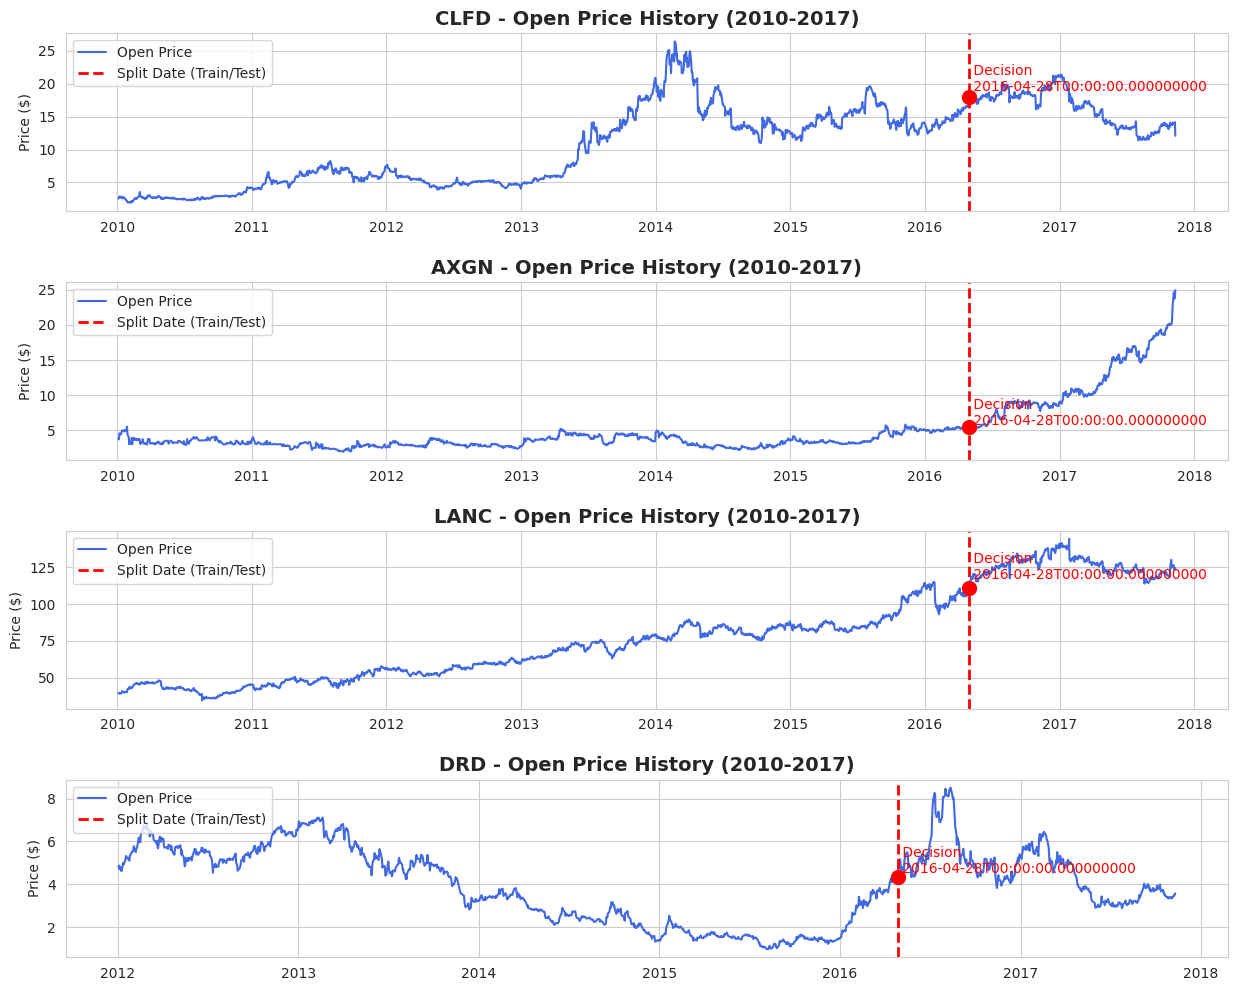

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Target tickers and decision day
target_tickers = final_targets
split_date = split_date

print(f"Plotting Open price trend for {target_tickers}...")

# Create canvas (4 rows 1 column)
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=False)
fig.subplots_adjust(hspace=0.4)

for i, ticker in enumerate(target_tickers):
    # Extract data
    df_stock = df_clean[df_clean['Ticker'] == ticker].copy()

    # Plotting
    ax = axes[i]
    ax.plot(df_stock['Date'], df_stock['Open'], label='Open Price', color='royalblue', linewidth=1.5)

    # Mark decision day (red line)
    ax.axvline(pd.to_datetime(split_date), color='red', linestyle='--', linewidth=2, label='Split Date (Train/Test)')

    # Mark buy point
    split_price = df_stock[df_stock['Date'] == split_date]
    if not split_price.empty:
        price_val = split_price['Open'].values[0]
        ax.scatter(pd.to_datetime(split_date), price_val, color='red', s=100, marker='o', zorder=5)
        ax.text(pd.to_datetime(split_date), price_val*1.05, f' Decision\n {split_date}', color='red', fontsize=10)

    ax.set_title(f"{ticker} - Open Price History (2010-2017)", fontsize=14, fontweight='bold')
    ax.set_ylabel("Price ($)")
    ax.legend(loc='upper left')

plt.show()

In [9]:
!pip install statsforecast utilsforecast numpy


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7cc7850316c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.12/dist-packages/scipy.libs/libscipy_openblas-b75cc656.

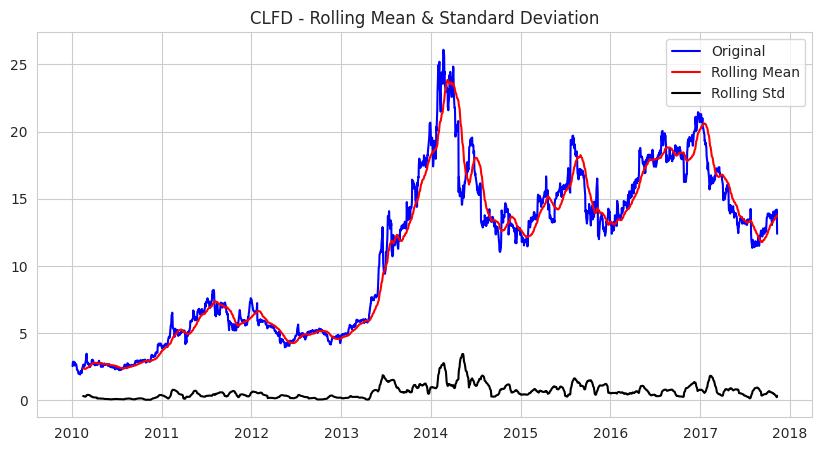

Results of Dickey-Fuller Test for [CLFD]:
P-value (0.4200) > 0.05, data is [Non-Stationary].


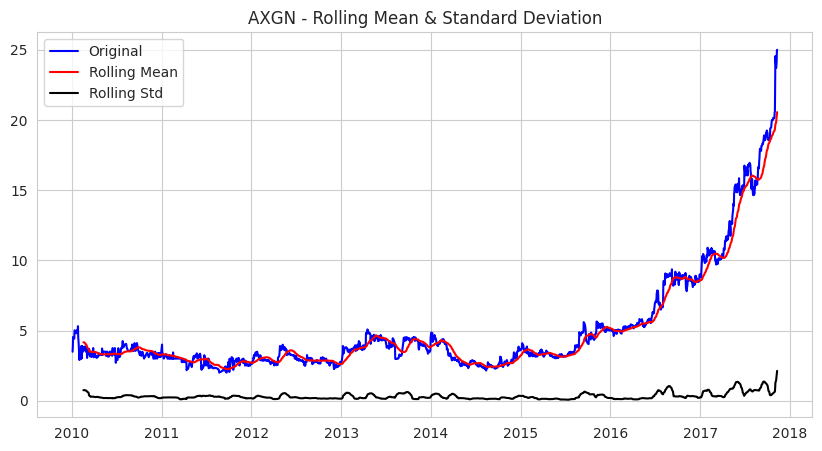

Results of Dickey-Fuller Test for [AXGN]:
P-value (1.0000) > 0.05, data is [Non-Stationary].


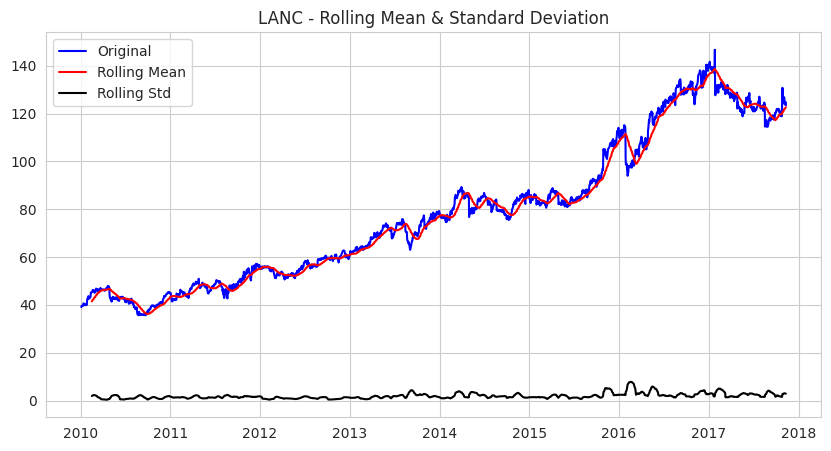

Results of Dickey-Fuller Test for [LANC]:
P-value (0.9090) > 0.05, data is [Non-Stationary].


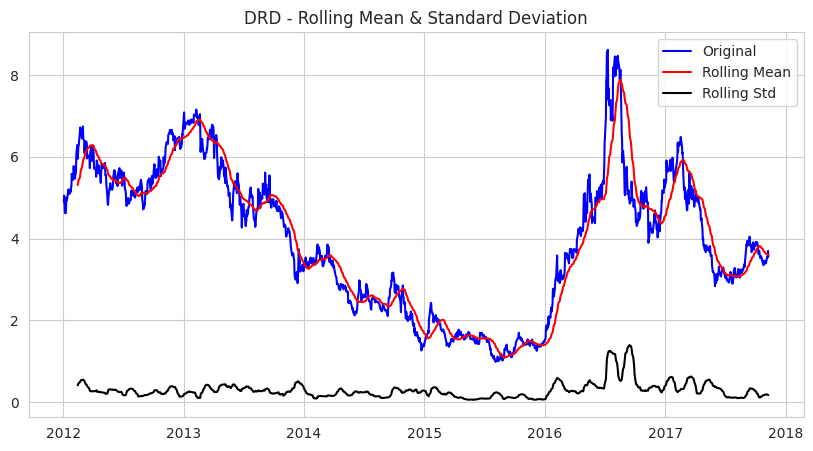

Results of Dickey-Fuller Test for [DRD]:
P-value (0.3922) > 0.05, data is [Non-Stationary].


In [10]:
import warnings
# StatsForecast core library
from statsforecast import StatsForecast
# Stationarity test library
from statsmodels.tsa.stattools import adfuller


# Ignore warnings
warnings.filterwarnings("ignore")

df_clean['Date'] = pd.to_datetime(df_clean['Date'])
target_tickers = final_targets
# Stationarity test
def test_stationarity(timeseries,title=ticker):
  rolmean = timeseries.rolling(window=30).mean()
  rolstd = timeseries.rolling(window=30).std()
  # Plotting
  plt.figure(figsize=(10, 5))
  plt.plot(timeseries, color='blue', label='Original')
  plt.plot(rolmean, color='red', label='Rolling Mean')
  plt.plot(rolstd, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title(f'{title} - Rolling Mean & Standard Deviation')
  plt.show()
  print(f'Results of Dickey-Fuller Test for [{title}]:')
  adft = adfuller(timeseries, autolag='AIC')
  output = pd.Series(adft[0:4], index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
  for key, values in adft[4].items():
    output['critical value (%s)' % key] = values
  if adft[1] <= 0.05:
    print(f"P-value ({adft[1]:.4f}) < 0.05, data is [Stationary].")
  else:
    print(f"P-value ({adft[1]:.4f}) > 0.05, data is [Non-Stationary].")

value_col = 'Close'
ticker_col = 'Ticker'

for ticker in target_tickers:
    # Filter data
    subset = df_clean[
        (df_clean[ticker_col] == ticker)
    ].sort_values('Date')

    ts = subset.set_index('Date')[value_col].dropna()

    if len(ts) > 0:
        test_stationarity(ts, title=ticker)

Performing seasonal decomposition on CLFD


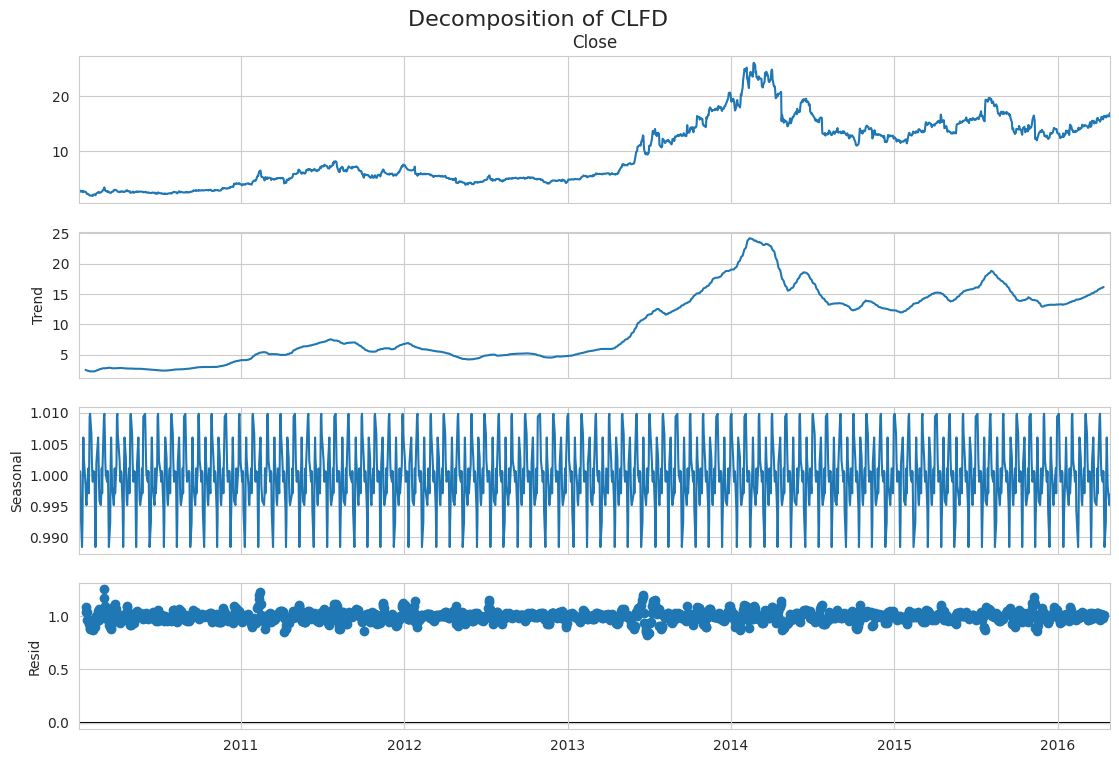

CLFD Residual stationarity test after removing trend and seasonality


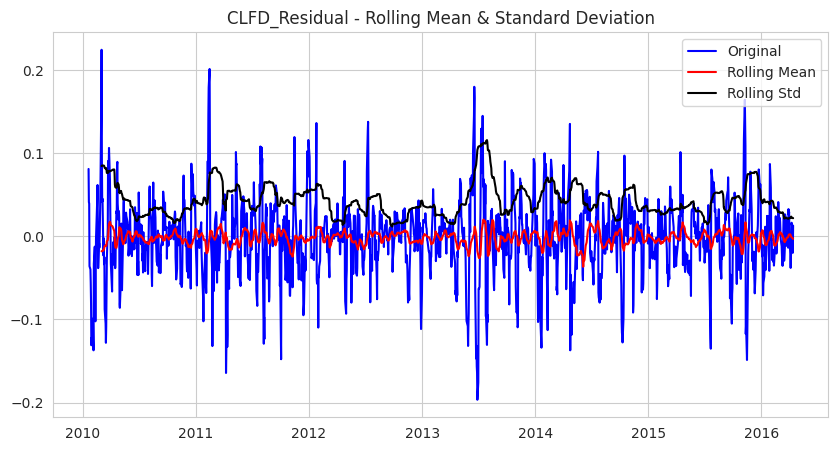

Results of Dickey-Fuller Test for [CLFD_Residual]:
P-value (0.0000) < 0.05, data is [Stationary].
Performing seasonal decomposition on AXGN


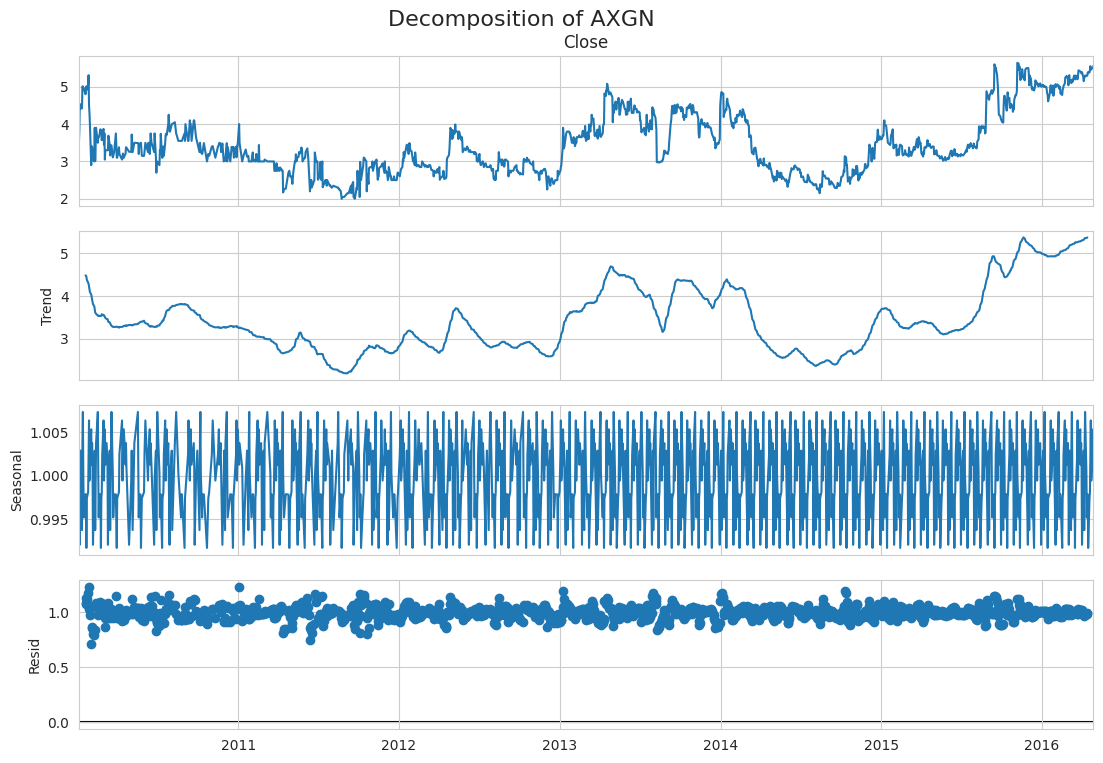

AXGN Residual stationarity test after removing trend and seasonality


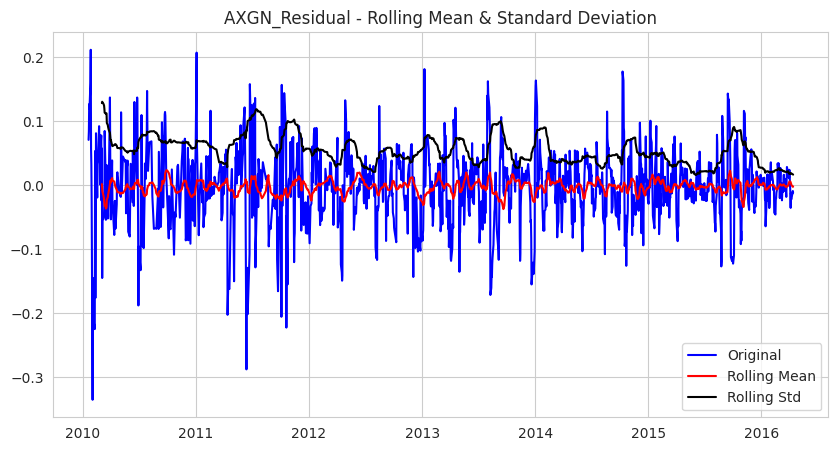

Results of Dickey-Fuller Test for [AXGN_Residual]:
P-value (0.0000) < 0.05, data is [Stationary].
Performing seasonal decomposition on LANC


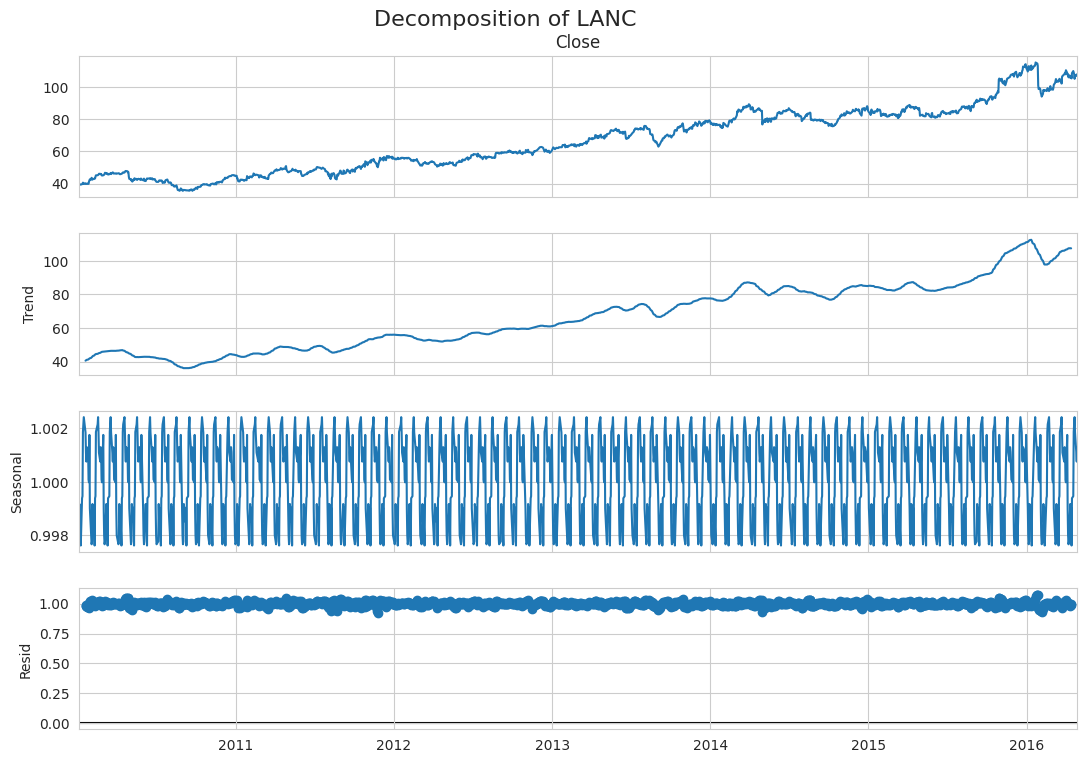

LANC Residual stationarity test after removing trend and seasonality


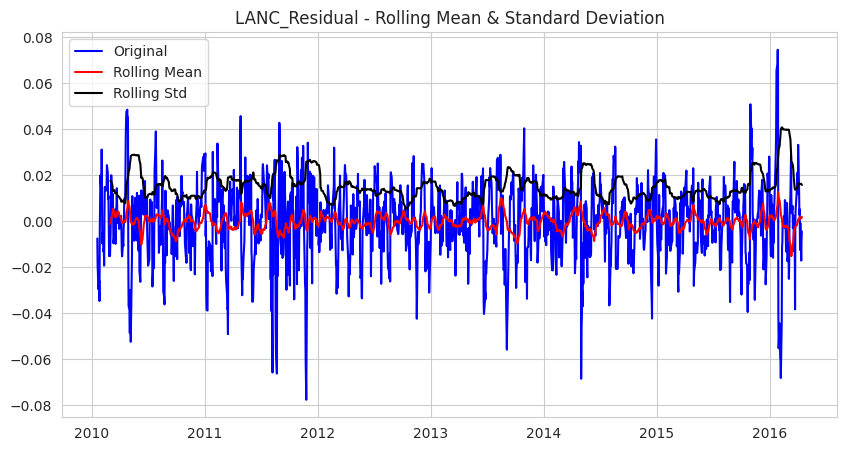

Results of Dickey-Fuller Test for [LANC_Residual]:
P-value (0.0000) < 0.05, data is [Stationary].
Performing seasonal decomposition on DRD


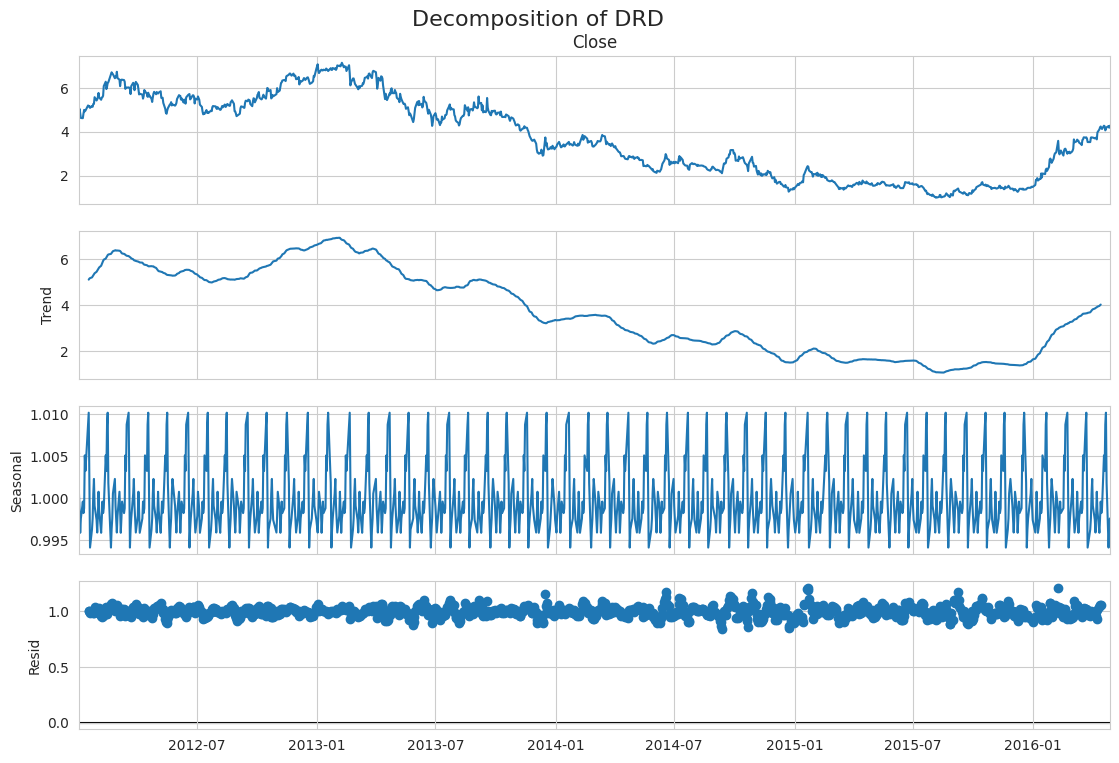

DRD Residual stationarity test after removing trend and seasonality


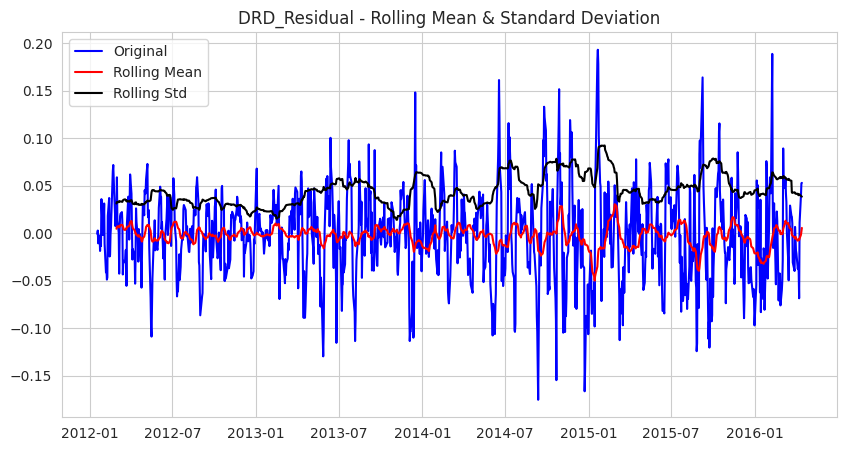

Results of Dickey-Fuller Test for [DRD_Residual]:
P-value (0.0000) < 0.05, data is [Stationary].


In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Monthly trend decomposition
season_period = 21
final_datasets = {}
decompose_results = {}

for ticker in target_tickers:
    # Filter data (keeping your original logic)
    subset = df_clean[
        (df_clean[ticker_col] == ticker) &
        (df_clean['Date'] < pd.to_datetime(split_date))
    ].sort_values('Date')
    # Standardize into a daily continuous time series
    ts = subset.set_index('Date')[value_col].asfreq('D').dropna()

    if len(ts) > season_period * 2:
        print(f"Performing seasonal decomposition on {ticker}")
        result = seasonal_decompose(ts, model='multiplicative', period=season_period)
        # detrended = ts / result.trend
        # deseasonalized = ts / result.seasonal
        # residual (pure part) = ts / (result.trend * result.seasonal)
        ts_residual = result.resid

        fig = result.plot()
        fig.set_size_inches(12, 8)
        fig.suptitle(f'Decomposition of {ticker}', fontsize=16)
        plt.show()

        # Residuals contain NaNs (head and tail), must dropna to pass into ADF test
        print(f"{ticker} Residual stationarity test after removing trend and seasonality")
        ts_residual_clean = ts_residual.dropna()
        # log
        ts_log_resid = np.log(ts_residual_clean + 1e-8)
        ts_final = ts_log_resid.dropna()
        final_datasets[ticker] = ts_final
        result = seasonal_decompose(ts, model='multiplicative', period=season_period)
        decompose_results[ticker] = {
                  'trend': result.trend,
                  'seasonal': result.seasonal
              }
        test_stationarity(ts_final, title=f"{ticker}_Residual")

    else:
        print(f"Ticker {ticker} data quantity insufficient for decomposition with period {season_period}")

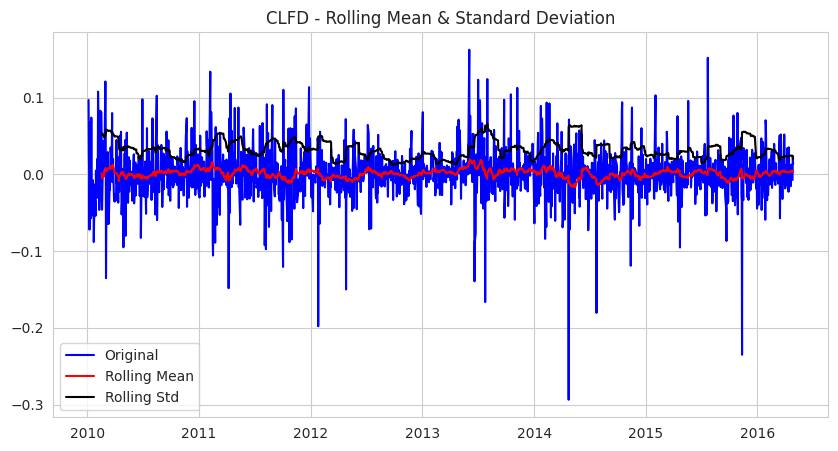

Results of Dickey-Fuller Test for [CLFD]:
P-value (0.0000) < 0.05, data is [Stationary].


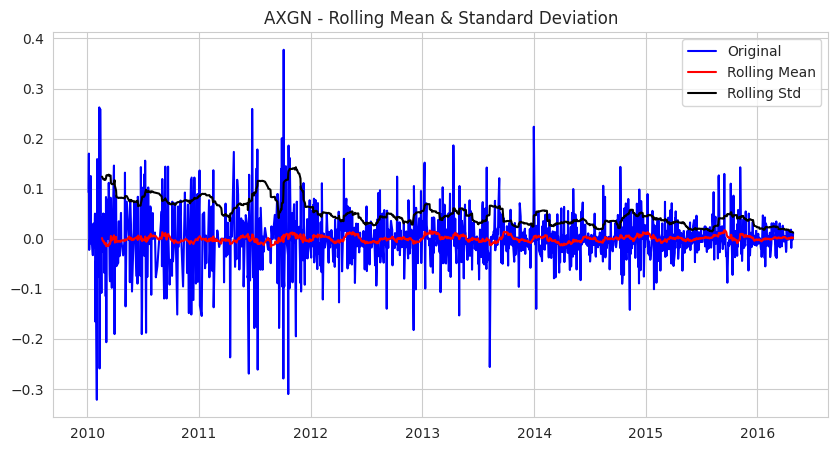

Results of Dickey-Fuller Test for [AXGN]:
P-value (0.0000) < 0.05, data is [Stationary].


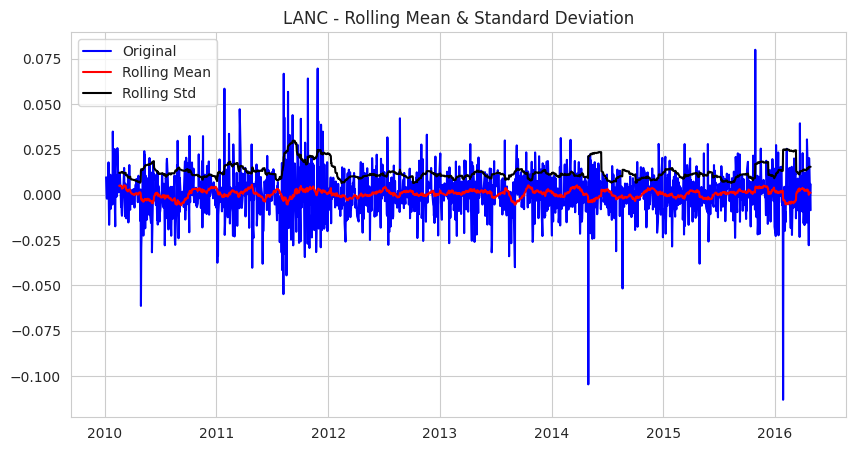

Results of Dickey-Fuller Test for [LANC]:
P-value (0.0000) < 0.05, data is [Stationary].


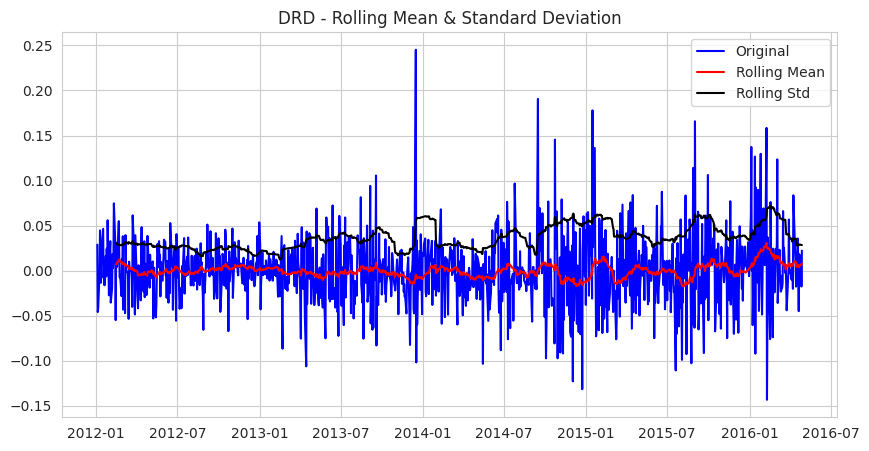

Results of Dickey-Fuller Test for [DRD]:
P-value (0.0000) < 0.05, data is [Stationary].


In [12]:
# Perform log & difference processing only
log_diff={}
for ticker in target_tickers:
    # Filter data
    subset = df_clean[
        (df_clean[ticker_col] == ticker) &
        (df_clean['Date'] < pd.to_datetime(split_date))
    ].sort_values('Date')
    # Standardize into a daily continuous time series
    ts = subset.set_index('Date')[value_col].asfreq('D').dropna()

    ts_log=np.log(ts)
    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    log_diff[ticker] = ts_log_diff
    test_stationarity(ts_log_diff, title=ticker)

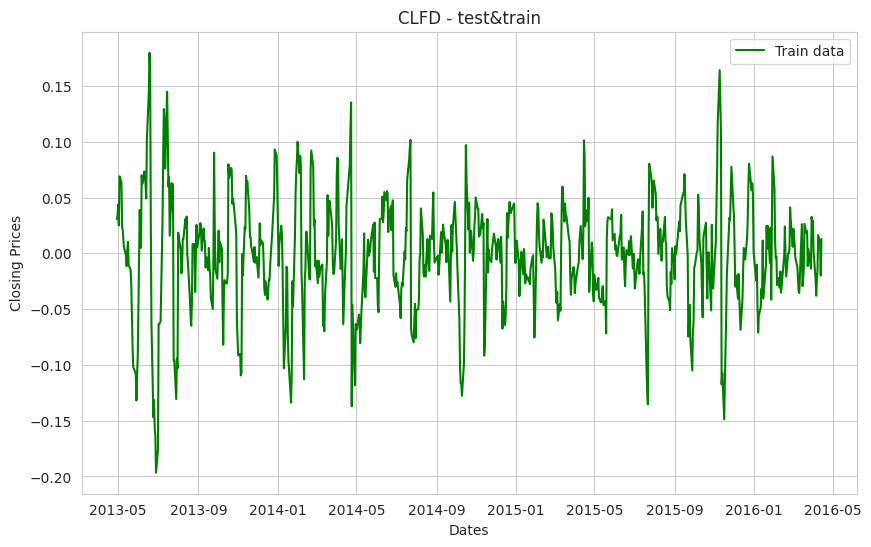

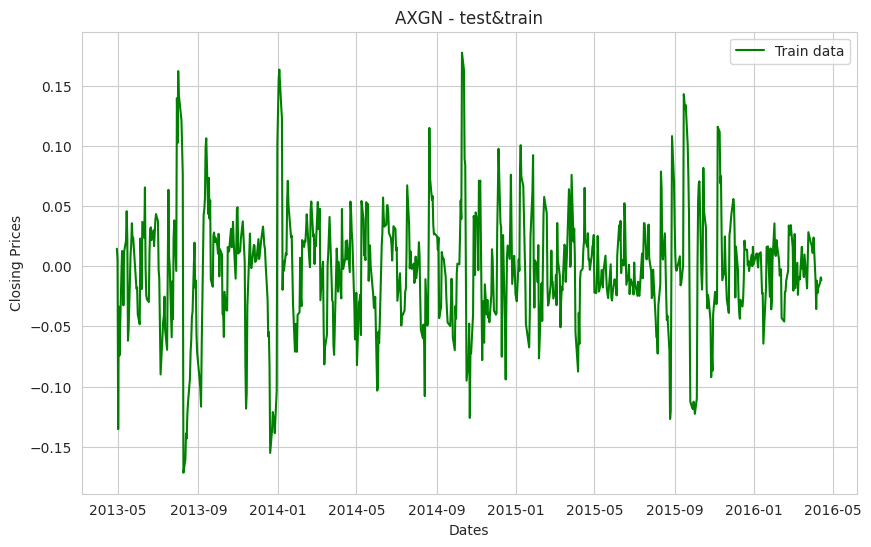

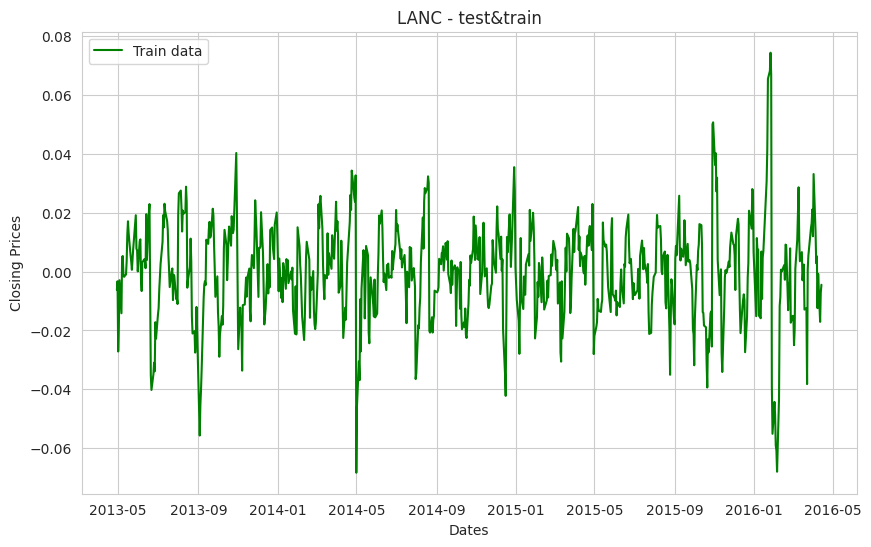

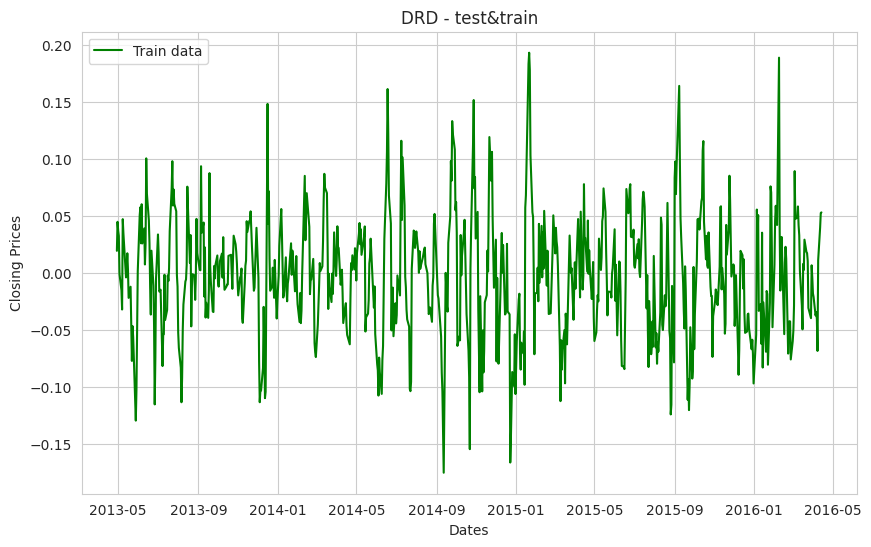

In [14]:
for ticker in target_tickers:
  split_dt = pd.to_datetime(split_date)
  start_dt = split_dt - pd.DateOffset(years=3)
  current_series = final_datasets[ticker]
  train_data = current_series[(current_series.index >= start_dt) & (current_series.index <= split_dt)]
  plt.figure(figsize=(10,6))
  plt.grid(True)
  plt.xlabel('Dates')
  plt.ylabel('Closing Prices')
  plt.plot(train_data, 'green', label='Train data')
  plt.legend()
  plt.title(f'{ticker} - test&train')
  plt.show()

Error calculating residuals for CLFD: slice(-1, None, None)
--- Check Results for CLFD ---
            Forecast  Lower_95  Upper_95  Spread
Date                                            
2016-04-29  0.009246       NaN       NaN     NaN
2016-05-02  0.005691       NaN       NaN     NaN
2016-05-03  0.002416       NaN       NaN     NaN


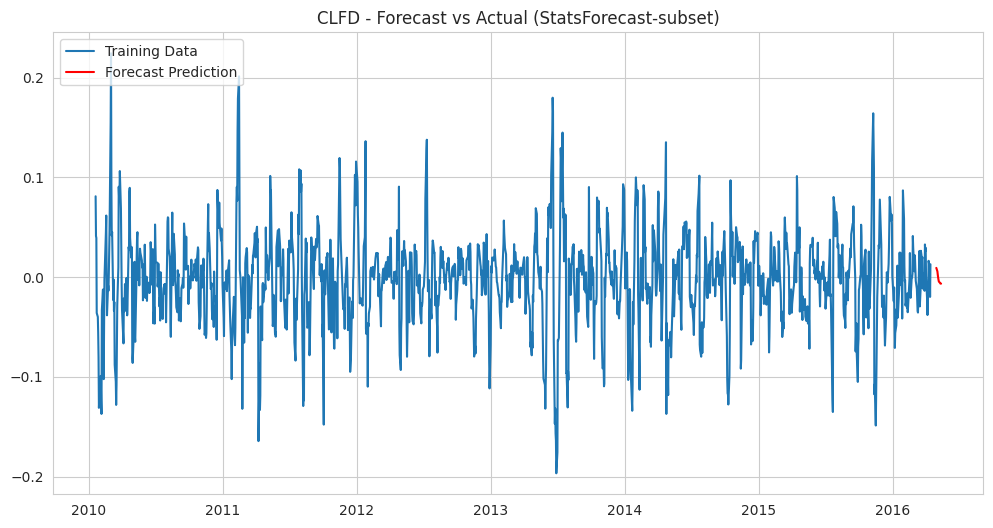

Error calculating residuals for AXGN: slice(-1, None, None)
--- Check Results for AXGN ---
            Forecast  Lower_95  Upper_95  Spread
Date                                            
2016-04-29 -0.012722       NaN       NaN     NaN
2016-05-02 -0.012448       NaN       NaN     NaN
2016-05-03 -0.011650       NaN       NaN     NaN


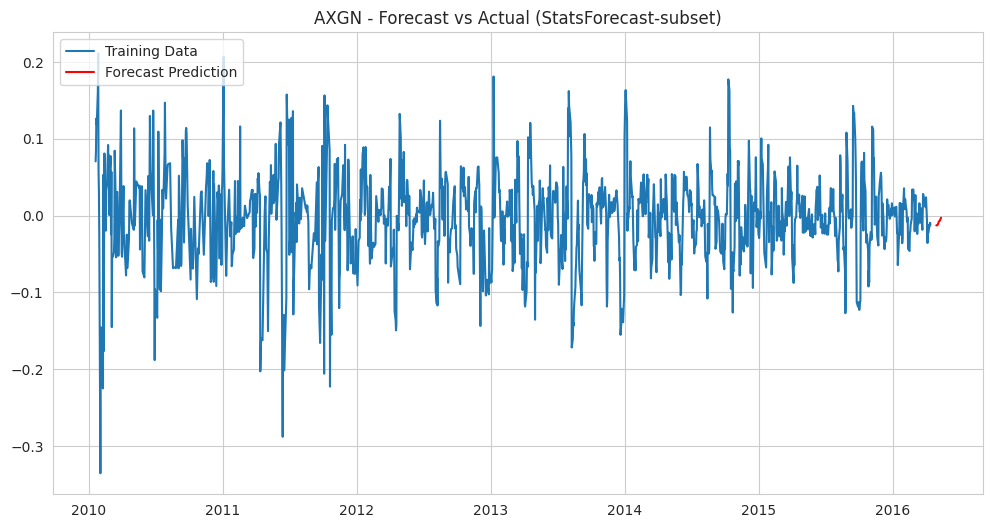

Error calculating residuals for LANC: slice(-1, None, None)
--- Check Results for LANC ---
            Forecast  Lower_95  Upper_95  Spread
Date                                            
2016-04-29 -0.002488       NaN       NaN     NaN
2016-05-02 -0.000833       NaN       NaN     NaN
2016-05-03  0.000451       NaN       NaN     NaN


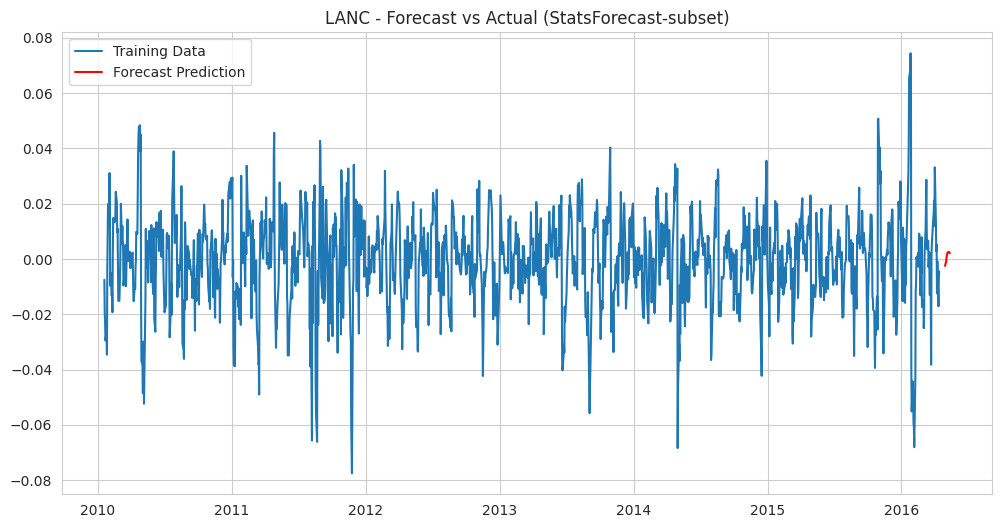

Error calculating residuals for DRD: slice(-1, None, None)
--- Check Results for DRD ---
            Forecast  Lower_95  Upper_95  Spread
Date                                            
2016-04-29  0.039035       NaN       NaN     NaN
2016-05-02  0.027528       NaN       NaN     NaN
2016-05-03  0.017206       NaN       NaN     NaN


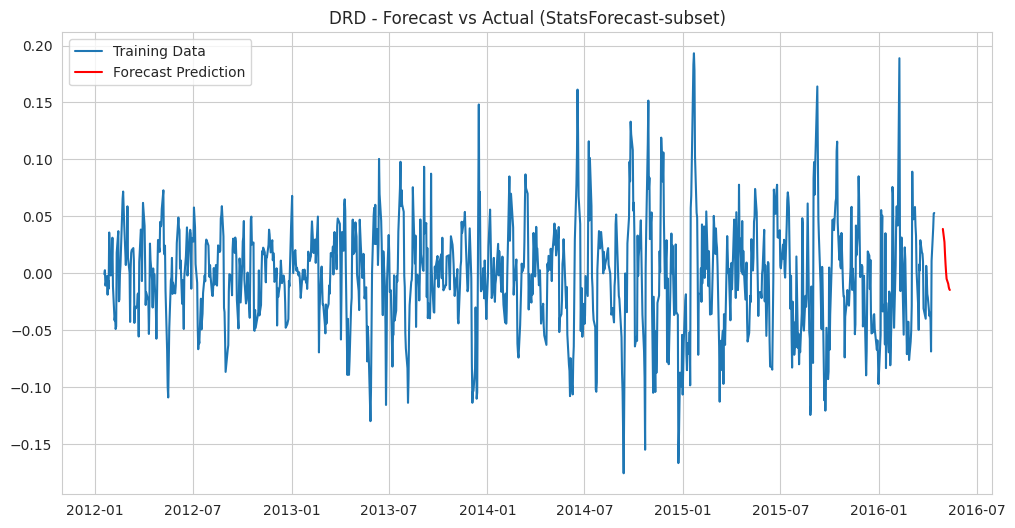

In [15]:
from statsforecast.models import AutoARIMA
from sklearn.metrics import mean_squared_error

trained_models = {}
prediction_results = {}
arima_residuals = {}

for ticker in target_tickers:
  #train data
  current_series = final_datasets[ticker]
  train_data = current_series[(current_series.index <= split_date)]
  model = AutoARIMA(season_length=1,
                      approximation=True,
                      stepwise=True)

  # Train model (accepts numpy array)
  model.fit(y=train_data.values)
  trained_models[ticker] = model
  # Residuals
  try:
      # Get in-sample predictions
      in_sample_preds = model.predict_in_sample()

      # Handle predict_in_sample return type (could be dict or array)
      if isinstance(in_sample_preds, dict) and 'mean' in in_sample_preds:
          fitted_values = in_sample_preds['mean']
      else:
          fitted_values = in_sample_preds

      # Calculate residuals
      # Ensure lengths match; fitted values might be missing parts due to differencing, alignment needed
      min_len = min(len(train_data.values), len(fitted_values))
      residuals = train_data.values[-min_len:] - fitted_values[-min_len:]

  except Exception as e:
      print(f"Error calculating residuals for {ticker}: {e}")
      residuals = np.zeros(len(train_data)) # Fallback, prevents interruption

  # Store calculated residuals in dictionary, Key is stock code, Value is residual array
  arima_residuals[ticker] = residuals
  # Forecast
  test_data = df_clean[
        (df_clean[ticker_col] == ticker) &
        (df_clean['Date'] > split_date)
  ].set_index('Date')[value_col]
  # Predict on the test set
  if len(test_data) > 0:
      n_periods = 10
      real_n_periods = min(n_periods, len(test_data))

      # level=[95] - 95% confidence interval
      forecast_dict = model.predict(h=real_n_periods, level=[95])

      current_test_data = test_data.iloc[:real_n_periods]
      # Extract data
      forecast_values = forecast_dict['mean']
      lower_conf = forecast_dict['lo-95']
      upper_conf = forecast_dict['hi-95']

      # Index alignment
      forecast_series = pd.Series(forecast_values, index=current_test_data.index)
      lower_series = pd.Series(lower_conf, index=current_test_data.index)
      upper_series = pd.Series(upper_conf, index=current_test_data.index)



      # Store data
      result_df = pd.DataFrame({
            'Actual': current_test_data,
            'Forecast': forecast_series,
            'Lower_95': lower_series,
            'Upper_95': upper_series,
            'Spread': upper_series - lower_series
        })
      prediction_results[ticker] = result_df


      print(f"--- Check Results for {ticker} ---")
      print(result_df[['Forecast', 'Lower_95', 'Upper_95', 'Spread']].head(3))

      # Plot verification
      plt.figure(figsize=(12, 6))
      plt.plot(train_data, label='Training Data')
      plt.plot(forecast_series, label='Forecast Prediction', color='red')


      plt.title(f'{ticker} - Forecast vs Actual (StatsForecast-subset)')
      plt.legend(loc='upper left')
      plt.grid(True)
      plt.show()

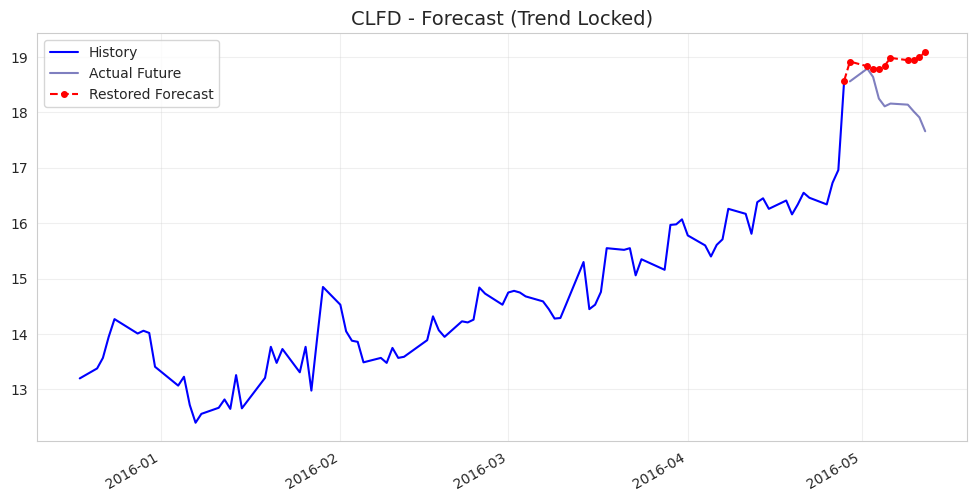

--- CLFD Final Price RMSE: 0.7997 ---


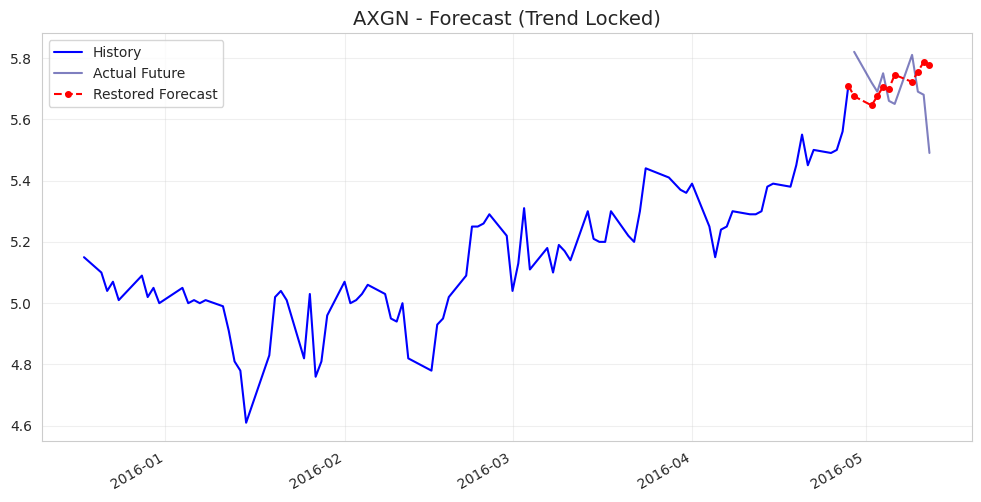

--- AXGN Final Price RMSE: 0.1205 ---


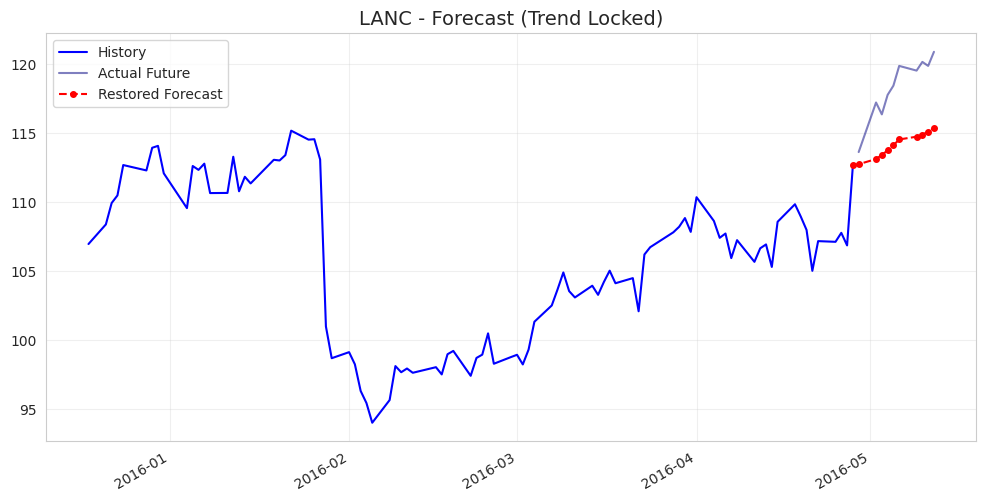

--- LANC Final Price RMSE: 4.3948 ---


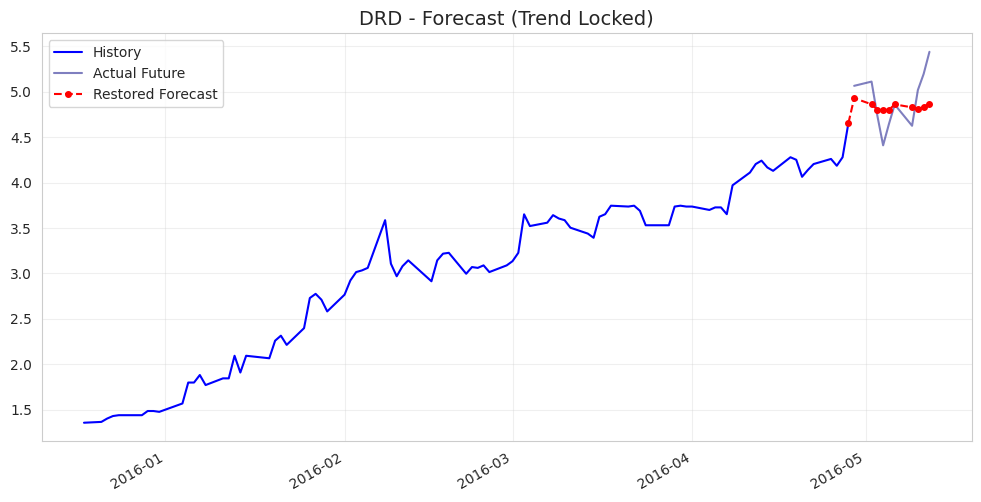

--- DRD Final Price RMSE: 0.2845 ---


In [16]:
from sklearn.metrics import mean_squared_error

final_restored_results = {}

for ticker in target_tickers:
  n_periods = 10
  # Ensure getting the correct slice length
  real_n_periods = min(n_periods, len(test_data)) # Note: Ensure test_data is correctly defined within the loop

  # --- Data Preparation ---
  test_data_full = df_clean[
        (df_clean[ticker_col] == ticker) &
        (df_clean['Date'] > split_date)
  ].set_index('Date')[value_col]

  train_data = df_clean[
        (df_clean[ticker_col] == ticker) &
        (df_clean['Date'] <= split_date)
  ].set_index('Date')[value_col]

  current_test_data = test_data_full.iloc[:real_n_periods]
  target_index = current_test_data.index

  # Extract ARIMA prediction results (Log Diff) ---
  df_pred_log = prediction_results[ticker].iloc[:real_n_periods]
  log_forecast = df_pred_log['Forecast'].iloc[:real_n_periods]
  log_lower = df_pred_log['Lower_95'].iloc[:real_n_periods]
  log_upper = df_pred_log['Upper_95'].iloc[:real_n_periods]

  # Lock Trend, let ARIMA guide the direction
  history_decomp = decompose_results.get(ticker)
  if history_decomp is None: continue

  # Get original decomposition components
  # full_trend has NaNs at the tail (due to moving average), we need to find the last valid value
  full_trend = history_decomp['trend']
  full_seasonal = history_decomp['seasonal']


  # Do not fit a straight line, but calculate "how much it rose on average per day in the last 30 days", then deduce at this speed.

  # Get clean Trend data
  valid_trend = full_trend.dropna()

  # Calculate daily change (Diff)
  trend_diff = valid_trend.diff()

  # Calculate average change of last 30 days (momentum)
  recent_slope = trend_diff.tail(30).mean()

  # Deduce starting from the last known point
  last_valid_trend = valid_trend.iloc[-1]

  # Generate future sequence: [last+slope, last+2*slope, ...]
  future_steps = np.arange(1, real_n_periods + 1)
  predicted_trend_vals = last_valid_trend + (recent_slope * future_steps)

  current_trend = pd.Series(predicted_trend_vals, index=target_index)

  # Seasonal prediction (Loop fill historical data)
  period = 5
  last_cycle = full_seasonal.iloc[-period:].values
  num_tiles = int(np.ceil(real_n_periods / period))
  predicted_seasonal_vals = np.tile(last_cycle, num_tiles)[:real_n_periods]
  current_seasonal = pd.Series(predicted_seasonal_vals, index=target_index)

  # Restoration and Alignment (Connect via Gap Ratio)

  pre_reexp = np.exp(log_forecast)
  pre_reexp_lower = np.exp(log_lower)
  pre_reexp_upper = np.exp(log_upper)

  # Basic restoration
  base_price_forecast = pre_reexp * current_trend * current_seasonal
  base_price_lower = pre_reexp_lower * current_trend * current_seasonal
  base_price_upper = pre_reexp_upper * current_trend * current_seasonal

  # Calculate Gap Ratio (Translation Alignment)

  # Get historical actual closing price
  last_actual_price = train_data.iloc[-1]

  # Theoretical Trend
  # Theoretical Seasonal
  last_seasonal_val = full_seasonal.iloc[-1]
  last_theoretical_price = last_valid_trend * last_seasonal_val

  # Calculate correction ratio (Gap Ratio)
  # Responsible for shifting the prediction line as a whole to the current stock price position
  gap_ratio = last_actual_price / last_theoretical_price

  # Apply correction
  final_price_forecast = base_price_forecast * gap_ratio
  final_price_lower = base_price_lower * gap_ratio
  final_price_upper = base_price_upper * gap_ratio

  true_close_price = current_test_data

  # Store results
  restored_df = pd.DataFrame({
      'Actual_Price': current_test_data,
      'Forecast_Price': final_price_forecast,
      'Lower_Price_95': final_price_lower,
      'Upper_Price_95': final_price_upper
  })
  final_restored_results[ticker] = restored_df

  # Plotting
  last_hist_date = train_data.index[-1]
  last_hist_val = train_data.iloc[-1]

  plot_pred_dates = [last_hist_date] + list(final_price_forecast.index)
  plot_pred_values = [last_hist_val] + list(final_price_forecast.values)

  # Logic: At the starting point (last historical day), both upper and lower bounds equal the actual price (no uncertainty)
  plot_lower_values = [last_hist_val] + list(final_price_lower.values)
  plot_upper_values = [last_hist_val] + list(final_price_upper.values)


  # Local zoom: Only plot the last 90 days
  zoom_days = 90
  plot_train_data = train_data.iloc[-zoom_days:]

  plt.figure(figsize=(12, 6))
  plt.plot(plot_train_data.index, plot_train_data.values, label='History', color='blue')
  plt.plot(true_close_price, label='Actual Future', color='navy', alpha=0.5)

  # Plot prediction line
  plt.plot(plot_pred_dates, plot_pred_values, label='Restored Forecast', color='red', linestyle='--', marker='o', markersize=4)

  plt.title(f'{ticker} - Forecast (Trend Locked)', fontsize=14)
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.gcf().autofmt_xdate()
  plt.show()

  # RMSE
  if len(final_price_forecast) > 0:
      rmse = np.sqrt(mean_squared_error(true_close_price, final_price_forecast))
      print(f"--- {ticker} Final Price RMSE: {rmse:.4f} ---")

--- Check Results for CLFD ---
            Forecast  Lower_95  Upper_95  Spread
Date                                            
2016-04-29  0.000851       NaN       NaN     NaN
2016-05-02  0.000939       NaN       NaN     NaN
2016-05-03 -0.002294       NaN       NaN     NaN
2016-05-04 -0.001184       NaN       NaN     NaN
2016-05-05  0.002059       NaN       NaN     NaN
2016-05-06 -0.000497       NaN       NaN     NaN
2016-05-09 -0.001380       NaN       NaN     NaN
2016-05-10  0.001584       NaN       NaN     NaN
2016-05-11  0.000053       NaN       NaN     NaN
2016-05-12 -0.001504       NaN       NaN     NaN


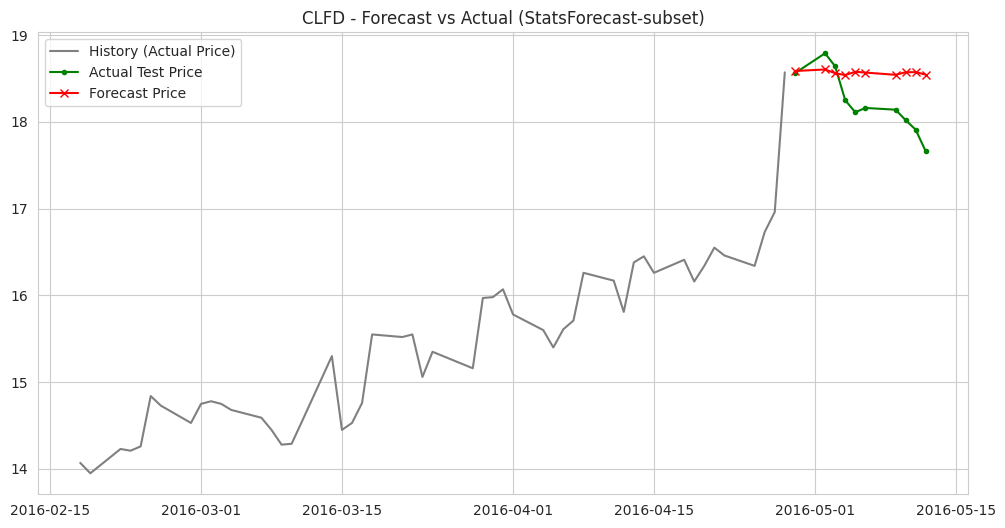

--- CLFD Prediction RMSE: 0.4686 ---
--- Check Results for AXGN ---
            Forecast  Lower_95  Upper_95  Spread
Date                                            
2016-04-29 -0.005274       NaN       NaN     NaN
2016-05-02 -0.000948       NaN       NaN     NaN
2016-05-03 -0.001692       NaN       NaN     NaN
2016-05-04 -0.001332       NaN       NaN     NaN
2016-05-05 -0.001275       NaN       NaN     NaN
2016-05-06 -0.001168       NaN       NaN     NaN
2016-05-09 -0.001085       NaN       NaN     NaN
2016-05-10 -0.001006       NaN       NaN     NaN
2016-05-11 -0.000933       NaN       NaN     NaN
2016-05-12 -0.000866       NaN       NaN     NaN


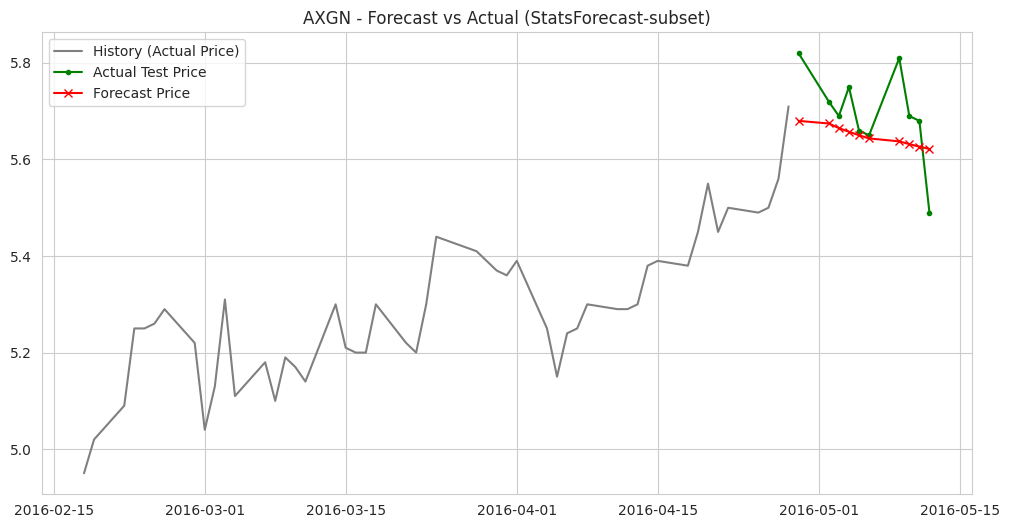

--- AXGN Prediction RMSE: 0.0918 ---
--- Check Results for LANC ---
            Forecast  Lower_95  Upper_95  Spread
Date                                            
2016-04-29  0.001501       NaN       NaN     NaN
2016-05-02  0.000633       NaN       NaN     NaN
2016-05-03  0.000633       NaN       NaN     NaN
2016-05-04  0.000633       NaN       NaN     NaN
2016-05-05  0.000633       NaN       NaN     NaN
2016-05-06  0.000633       NaN       NaN     NaN
2016-05-09  0.000633       NaN       NaN     NaN
2016-05-10  0.000633       NaN       NaN     NaN
2016-05-11  0.000633       NaN       NaN     NaN
2016-05-12  0.000633       NaN       NaN     NaN


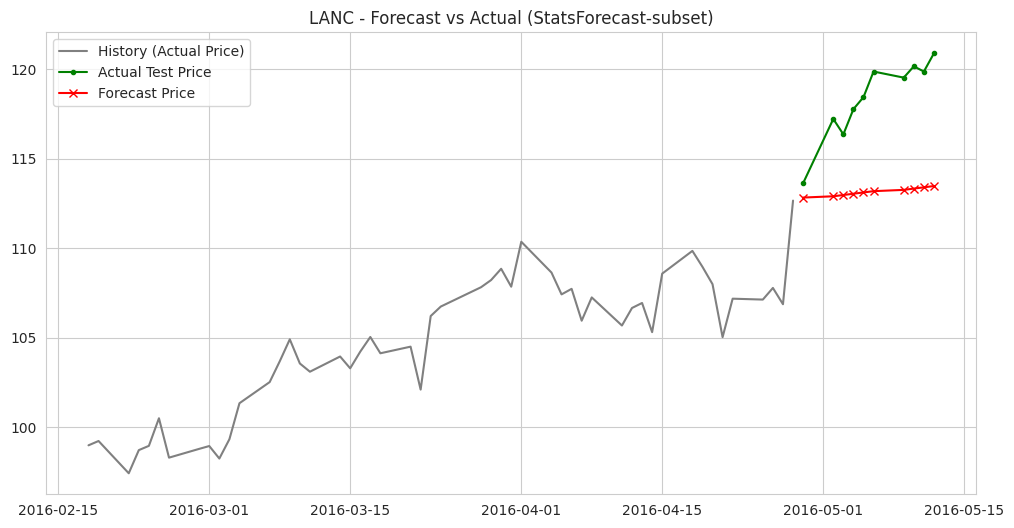

--- LANC Prediction RMSE: 5.5583 ---
--- Check Results for DRD ---
                Forecast  Lower_95  Upper_95  Spread
Date                                                
2016-04-29 -1.848657e-03       NaN       NaN     NaN
2016-05-02  1.543863e-04       NaN       NaN     NaN
2016-05-03 -1.289322e-05       NaN       NaN     NaN
2016-05-04  1.076747e-06       NaN       NaN     NaN
2016-05-05 -8.992207e-08       NaN       NaN     NaN
2016-05-06  7.509634e-09       NaN       NaN     NaN
2016-05-09 -6.271498e-10       NaN       NaN     NaN
2016-05-10  5.237497e-11       NaN       NaN     NaN
2016-05-11 -4.373974e-12       NaN       NaN     NaN
2016-05-12  3.652824e-13       NaN       NaN     NaN


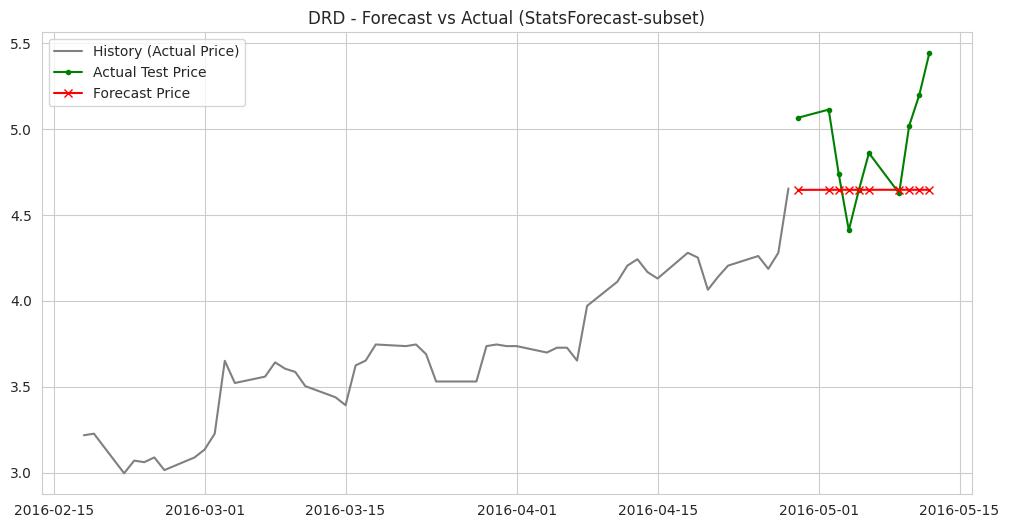

--- DRD Prediction RMSE: 0.3974 ---


In [13]:
from statsforecast.models import AutoARIMA
from sklearn.metrics import mean_squared_error

trained_models = {}
prediction_results = {}
arima_residuals = {}

for ticker in target_tickers:
  # train data
  current_series = log_diff[ticker]
  train_data = current_series[(current_series.index <= split_date)]
  history_data = df_clean[
        (df_clean[ticker_col] == ticker) &
        (df_clean['Date'] <= split_date)
        ].set_index('Date')[value_col]

  # Get the last actual price of the training set and convert to Log as the baseline for accumulation
  last_actual_price = history_data.iloc[-1]
  last_actual_log = np.log(last_actual_price)
  model = AutoARIMA(season_length=1,
                      approximation=True,
                      stepwise=True)

  # Train model (Note: statsforecast usually accepts numpy array)
  model.fit(y=train_data.values)
  trained_models[ticker] = model

  in_sample_result = model.predict_in_sample()
  fitted_values = in_sample_result['fitted']

  # Calculate residuals (Residuals = Actual - Fitted)
  # train_data.values
  residuals_array = (train_data.values - fitted_values)

  # Convert residuals to Series and align time index
  # So what you store in the dictionary is a Series with dates, convenient for subsequent ACF plotting or time series analysis
  residuals = pd.Series(residuals_array, index=train_data.index)

  # Store calculated residuals in dictionary, Key is stock code, Value is residual array
  arima_residuals[ticker] = residuals
  # Forecast
  test_data = df_clean[
        (df_clean[ticker_col] == ticker) &
        (df_clean['Date'] > split_date)
  ].set_index('Date')[value_col]
  # Predict on the test set
  if len(test_data) > 0:
      n_periods = 10
      real_n_periods = min(n_periods, len(test_data))

      # level=[95] - 95% confidence interval
      # This step returns a dictionary, like {'mean': [...], 'lo-95': [...], 'hi-95': [...]}
      forecast_dict = model.predict(h=real_n_periods, level=[95])
      # Actual test data
      current_test_data = test_data.iloc[:real_n_periods]
      # Extract data
      forecast_values = forecast_dict['mean']
      lower_conf = forecast_dict['lo-95']
      upper_conf = forecast_dict['hi-95']

      # Organize into Series (Index alignment)
      forecast_series = pd.Series(forecast_values, index=current_test_data.index)
      lower_series = pd.Series(lower_conf, index=current_test_data.index)
      upper_series = pd.Series(upper_conf, index=current_test_data.index)

      # Store data
      result_df = pd.DataFrame({
            'Actual': current_test_data,
            'Forecast': forecast_series,
            'Lower_95': lower_series,
            'Upper_95': upper_series,
            'Spread': upper_series - lower_series
        })
      prediction_results[ticker] = result_df

      # Start restoring data
      # Formula: Predicted Log Price = Last Historical Log Price + Cumulative Sum of Predicted Changes (cumsum)
      pred_log_price = last_actual_log + np.cumsum(forecast_values)
      lower_log_price = last_actual_log + np.cumsum(lower_conf)
      upper_log_price = last_actual_log + np.cumsum(upper_conf)

      # Restore Log (Inverse Log / Exp) -> Get Original Price
      pred_price = np.exp(pred_log_price)
      lower_price = np.exp(lower_log_price)
      upper_price = np.exp(upper_log_price)

      # Organize restored data into Series (Time alignment)
      pred_price_series = pd.Series(pred_price, index=current_test_data.index)
      lower_price_series = pd.Series(lower_price, index=current_test_data.index)
      upper_price_series = pd.Series(upper_price, index=current_test_data.index)

      print(f"--- Check Results for {ticker} ---")
      print(result_df[['Forecast', 'Lower_95', 'Upper_95', 'Spread']].head(10))

      # Plot verification
      plt.figure(figsize=(12, 6))
      # Plot history part (Take last 50 days to see the connection clearly)
      plt.plot(history_data.iloc[-50:], label='History (Actual Price)', color='gray')
      # Plot actual test data
      plt.plot(current_test_data, label='Actual Test Price', color='green', marker='.')
      plt.plot(pred_price_series, label='Forecast Price', color='red', marker='x')
      plt.title(f'{ticker} - Forecast vs Actual (StatsForecast-subset)')
      plt.legend(loc='upper left')
      plt.grid(True)
      plt.show()

      # Calculate RMSE
      rmse = np.sqrt(mean_squared_error(current_test_data, pred_price_series))
      print(f"--- {ticker} Prediction RMSE: {rmse:.4f} ---")

prepare Monte Carlo Simulation for ['CLFD' 'AXGN' 'LANC' 'DRD']
mean_return: 0.003959
var: 0.001813
drift: 0.003052
stdev: 0.042578
CLFD simulation done
AXGN simulation done
LANC simulation done
DRD simulation done


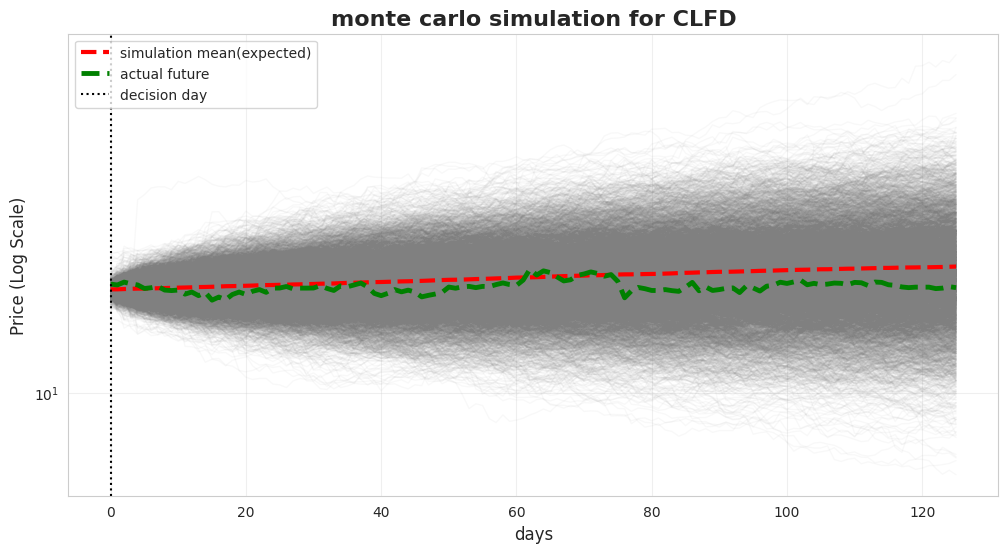

--- Model Credibility Check ---
Backtest Coverage: 100.00%
(Expected ~90%. If <70%, model underestimates volatility.)
RMSE (Error): 1.28
------------------------------
risk report(0.5years after):
right now price:$18.01
worst 5% price:$12.30
VaR_percent: -31.72%
up prob: 62.9


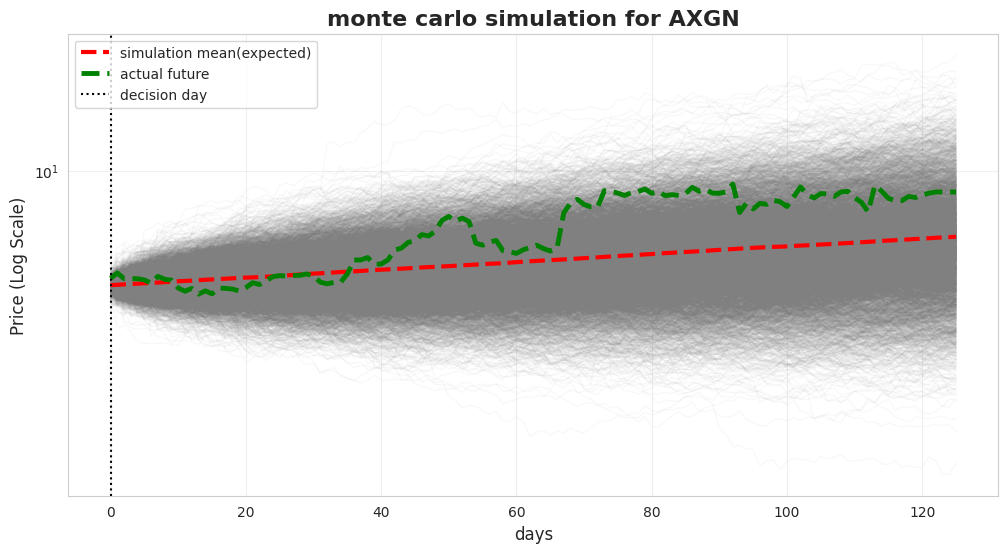

--- Model Credibility Check ---
Backtest Coverage: 92.86%
(Expected ~90%. If <70%, model underestimates volatility.)
RMSE (Error): 1.49
------------------------------
risk report(0.5years after):
right now price:$5.52
worst 5% price:$4.41
VaR_percent: -20.08%
up prob: 79.6


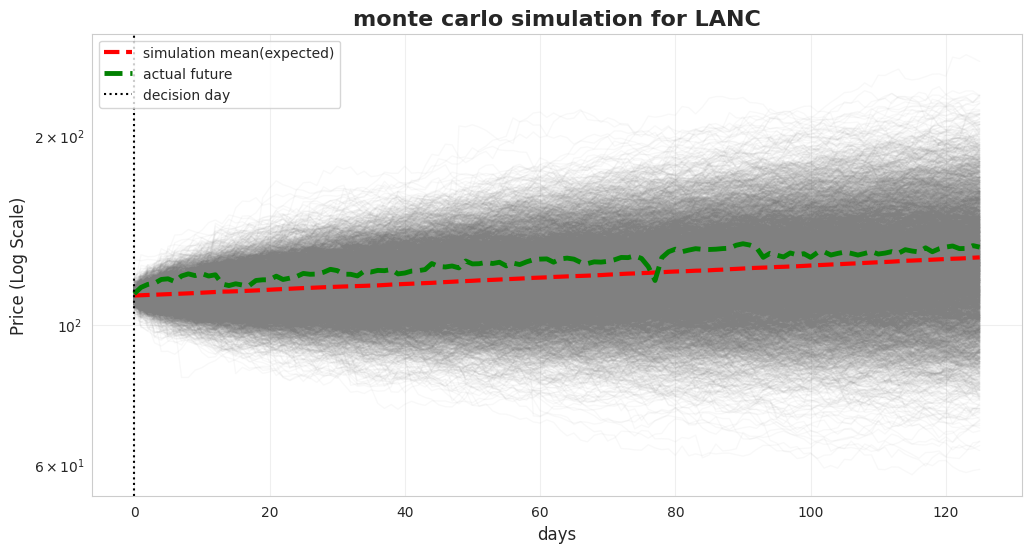

--- Model Credibility Check ---
Backtest Coverage: 100.00%
(Expected ~90%. If <70%, model underestimates volatility.)
RMSE (Error): 6.50
------------------------------
risk report(0.5years after):
right now price:$111.17
worst 5% price:$90.23
VaR_percent: -18.84%
up prob: 72.8


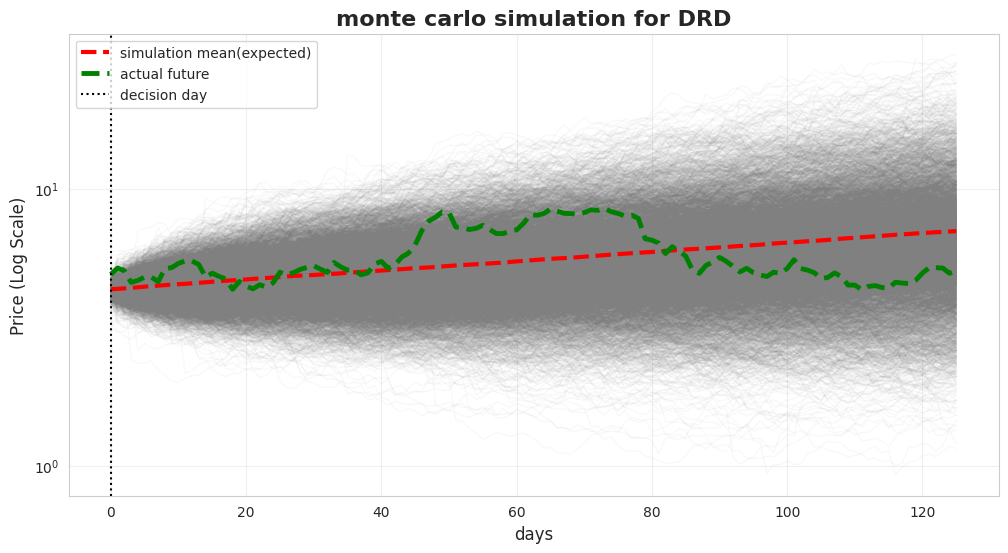

--- Model Credibility Check ---
Backtest Coverage: 96.83%
(Expected ~90%. If <70%, model underestimates volatility.)
RMSE (Error): 1.55
------------------------------
risk report(0.5years after):
right now price:$4.33
worst 5% price:$2.83
VaR_percent: -34.68%
up prob: 78.5


In [17]:
# Average Daily Return (Mean Return): Drift

# Volatility (Variance/Std Dev)

from scipy.stats import norm
from scipy.stats import t

#set variances
tickers = final_targets
split_date = split_date
day_to_simulate = 126 # future 0.5y
num_simulations = 5000
window_size=126*2
full_df['Date'] = pd.to_datetime(full_df['Date'])

print(f"prepare Monte Carlo Simulation for {tickers}")

#build a dictionary
mc_params = {}

# Extract data
for ticker in tickers:
  df_stock = full_df[full_df['Ticker']== ticker].set_index('Date')
  df_stock.sort_index(inplace=True)
  price_series = df_stock['Open'] # Open Price
  train_data=price_series[price_series.index <= split_date]
  test_data=price_series[price_series.index > split_date].head(day_to_simulate)
  train_recent = train_data.tail(window_size)
  # caculate mean_return
  # Financial asset prices follow a log-normal distribution, mathematically more accurate
  log_returns = np.log(train_recent / train_recent.shift(1)).dropna()
  mean_return = log_returns.mean() #average daily return

  # Calculate weighted standard deviation (Decay factor span=90days)
  stdev = log_returns.ewm(span=90).std().iloc[-1]
  var=stdev**2
  drift = mean_return - 0.5 * var # Calculate drift rate

  # Store in dictionary
  mc_params[ticker] = {
      'log_returns' : log_returns,
      'mean_return' : mean_return,
      'drift' : drift,
      'var' : var,
      'stdev' : stdev,
      'last_price' : train_data.iloc[-1],
      'train_data' : train_data,
      'test_data' : test_data

  }

print(f"mean_return: {mean_return:.6f}")
print(f"var: {var:.6f}")
print(f"drift: {drift:.6f}")
print(f"stdev: {stdev:.6f}")

#path generation
#simulation
simulations = {}
#degree of freedom
dof=5

for ticker, params in mc_params.items():
  drift = params['drift']
  stdev = params['stdev']
  last_price = params['last_price']
  # generate normal dist random value, daily random trials
  z=t.rvs(dof,size=(day_to_simulate,num_simulations))
  t_var = dof / (dof - 2)
  z = z / np.sqrt(t_var)
  eps = drift + stdev * z
  log_paths = np.cumsum(eps, axis=0)
  simulations[ticker] = last_price * np.exp(log_paths)

  print(f"{ticker} simulation done")

  #Visualization & risk analysis

for ticker,price_path in simulations.items():
  params = mc_params[ticker]
  last_price = params['last_price']
  test_data = params['test_data']
  drift = params['drift']

  # Extract historical log returns
  hist_ret = params['log_returns']

  plt.figure(figsize=(12,6))

  plt.plot(price_path,color='gray',alpha=0.05,linewidth=1)

  # Plot simulation mean line (Red dashed line - Mathematical Expectation)
  # axis=1 means calculating the average of 1000 universes for each day
  plt.plot(price_path.mean(axis=1),color='red',linestyle='--',linewidth=3,label='simulation mean(expected)')

  #real price
  real_days = len(test_data)
  if real_days >0:
    plt.plot(np.arange(real_days),test_data.values,color='green',linestyle='--',linewidth=3.5,label='actual future')

  #plot detail
  plt.title(f'monte carlo simulation for {ticker}',fontsize=16,fontweight='bold')
  plt.xlabel('days',fontsize=12)
  plt.ylabel('price',fontsize=12)
  plt.axvline(0,color='black',linestyle=':',label='decision day')
  plt.legend(loc='upper left')
  plt.grid(True,alpha=0.3)
  # Log scale
  plt.yscale('log')
  plt.ylabel('Price (Log Scale)')
  plt.show()
  if len(test_data) > 0:
      # Calculate 5% and 95% quantile lines for each simulated day
      lower_bound = np.percentile(price_path, 5, axis=1) # Pessimistic bound
      upper_bound = np.percentile(price_path, 95, axis=1) # Optimistic bound

      # Truncate bounds to matching length (since simulation might be longer than test_data)
      days_to_compare = min(len(test_data), len(lower_bound))
      real_price_segment = test_data.values[:days_to_compare]
      lower_segment = lower_bound[:days_to_compare]
      upper_segment = upper_bound[:days_to_compare]

      # Check if actual price falls within the interval for each day
      is_in_interval = (real_price_segment >= lower_segment) & (real_price_segment <= upper_segment)
      coverage_ratio = is_in_interval.mean() * 100

      print(f"--- Model Credibility Check ---")
      print(f"Backtest Coverage: {coverage_ratio:.2f}%")
      print(f"(Expected ~90%. If <70%, model underestimates volatility.)")

      # Simple error metric (RMSE) - Compare Actual Price vs Simulation Mean
      sim_mean_segment = price_path.mean(axis=1)[:days_to_compare]
      rmse = np.sqrt(((sim_mean_segment - real_price_segment) ** 2).mean())
      print(f"RMSE (Error): {rmse:.2f}")
      print("-" * 30)

  #VaR calculation

  final_prices = price_path[-1]

  #worst 5%
  price_at_risk_95=np.percentile(final_prices,5)

  #VaR (Maximum Potential Loss Ratio)
  var_percent = (price_at_risk_95 - last_price) / last_price *100

  #up prob
  prob_up = (final_prices > last_price).sum() / len(final_prices)*100

  print(f"risk report(0.5years after):")
  print(f"right now price:${last_price:.2f}")
  print(f"worst 5% price:${price_at_risk_95:.2f}")
  print(f"VaR_percent: {var_percent:.2f}%")
  print(f"up prob: {prob_up:.1f}")